# Machine Learning Assignment 2
## Murtaza Hussain (29449) and Muhammad Asad ur Rehman (29456)

In [188]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import classification_report, accuracy_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_classif, RFE, chi2, SequentialFeatureSelector, f_regression
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from lazypredict.Supervised import LazyClassifier
from IPython.display import display

pd.options.display.float_format = '{:,.4f}'.format

In [189]:
# Data Loader loads data from UCI-ML Repo
def load_datasets():
    # Classification Datasets
    c_cancer = pd.read_csv("./Classification.CancerMB.csv").iloc[:, :32]
    c_mice_expression = pd.read_csv("./Classification.Mice.Expression.csv")#.iloc[:, :25]
    c_adult_income = pd.read_csv("./Classification.Adult.Income.csv")
    # Regression Datasets
    r_life_expectancy = pd.read_csv("./Regression.Life.Expectancy.csv")
    r_appartment_rent = pd.read_csv("./Regression.Appartment.Rent.csv")
    r_song_popularity = pd.read_csv("./Regression.Song.Popularity.csv")
    
    return c_cancer, c_mice_expression, c_adult_income, r_life_expectancy, r_appartment_rent, r_song_popularity

In [190]:
# This function performs a missing value analysis on each column of the dataset, helps you decide on what to do in cleaning process
def null_check(df):
    null_columns = []
    for column in df.columns:
        print("Column Name:", column)
        print("Column DataType:", df[column].dtype)
        if df[column].dtype != 'float64' and df[column].dtype != 'int64':
            print("Column unique values:", df[column].unique())
        print("Column has null:", df[column].isnull().any())

        
        if df[column].isnull().any() == True:
            print("Column Null Count:", df[column].isnull().sum())
            null_columns.append(column)
        print("\n")
    return null_columns

In [191]:
# This function drops any null columns and missing values
# This is where you decide whether to remove NULL rows (which will reduce the size of Dataset) or remove NULL columns entirely. You can also choose a combination of both.
def clean_data(df, drop_columns, missing_value = False):
    # Remove unnecessary columns
    df.drop(drop_columns, axis=1, inplace=True)
    # Drop rows with any missing values
    if missing_value == False:
        df.dropna(inplace=True)
    else:
        df.fillna(missing_value, inplace=True)
    return df

In [192]:
# Transforms categorical and numberical data into numerical data
def transform_data(df):
    # Encode categorical variables
    label_encoder = LabelEncoder()
    print("Categorical columns:", df.select_dtypes(include=['object']).columns)
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = label_encoder.fit_transform(df[col])
    
    # Standardize numerical features
    scaler = StandardScaler()
    print("Numerical columns:", df.select_dtypes(include=['float64', 'int64']).columns)
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(numerical_cols) > 0:
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
    return df

In [171]:
def fwpMethodsClassification(df, target_name):
    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []
    benchmarks = []

    # Apply MinMax scaling to ensure non-negative values
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize the classifiers
    lr_classifier = LogisticRegression()
    rf_classifier = RandomForestClassifier()
    knn_classifier = KNeighborsClassifier()

    # Initialize k-fold cross-validation where folds = 5
    k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Apply Benchmarks:
    lr_benchmark_scores = cross_val_score(lr_classifier, X_scaled, y, cv=k_fold, scoring='accuracy')
    benchmarks.append({ 'Classifier': 'Logistic Regression', 'Accuracy': lr_benchmark_scores.mean()})
    rf_benchmark_scores = cross_val_score(rf_classifier, X_scaled, y, cv=k_fold, scoring='accuracy')
    benchmarks.append({ 'Classifier': 'Random Forest', 'Accuracy': rf_benchmark_scores.mean()})
    knn_benchmark_scores = cross_val_score(knn_classifier, X_scaled, y, cv=k_fold, scoring='accuracy')
    benchmarks.append({ 'Classifier': 'K-Nearest Neighbors', 'Accuracy': knn_benchmark_scores.mean()})

    # Loop through different k values
    for k in [3, 5, 10]:
        # Apply chi-squared filter
        X_chi2 = SelectKBest(score_func=chi2, k=k).fit_transform(X_scaled, y)
        lr_chi2_scores = cross_val_score(lr_classifier, X_chi2, y, cv=k_fold, scoring='accuracy')
        results.append({ 'k': k, 'Method': 'Chi-Squared', 'Classifier': 'Logistic Regression', 'Accuracy': lr_chi2_scores.mean()})
        rf_chi2_scores = cross_val_score(rf_classifier, X_chi2, y, cv=k_fold, scoring='accuracy')
        results.append({ 'k': k, 'Method': 'Chi-Squared', 'Classifier': 'Random Forest', 'Accuracy': rf_chi2_scores.mean()})
        knn_chi2_scores = cross_val_score(knn_classifier, X_chi2, y, cv=k_fold, scoring='accuracy')
        results.append({ 'k': k, 'Method': 'Chi-Squared', 'Classifier': 'K-Nearest Neighbors', 'Accuracy': knn_chi2_scores.mean()})

        # Apply forward selection wrapper
        lr_forward_selector = SequentialFeatureSelector(lr_classifier, n_features_to_select=k, direction='forward')
        X_forward = lr_forward_selector.fit_transform(X_scaled, y)
        lr_forward_scores = cross_val_score(lr_classifier, X_forward, y, cv=k_fold, scoring='accuracy')
        results.append({ 'k': k, 'Method': 'Forward Feature Selection (FFS)', 'Classifier': 'Logistic Regression', 'Accuracy': lr_forward_scores.mean()})
        rf_forward_scores = cross_val_score(rf_classifier, X_forward, y, cv=k_fold, scoring='accuracy')
        results.append({ 'k': k, 'Method': 'Forward Feature Selection (FFS)', 'Classifier': 'Random Forest', 'Accuracy': rf_forward_scores.mean()})
        knn_forward_scores = cross_val_score(knn_classifier, X_forward, y, cv=k_fold, scoring='accuracy')
        results.append({ 'k': k, 'Method': 'Forward Feature Selection (FFS)', 'Classifier': 'K-Nearest Neighbors', 'Accuracy': knn_forward_scores.mean()})

        # Apply backward selection wrapper
        lr_backward_selector = SequentialFeatureSelector(lr_classifier, n_features_to_select=k, direction='backward')
        X_backward = lr_backward_selector.fit_transform(X_scaled, y)
        lr_backward_scores = cross_val_score(lr_classifier, X_backward, y, cv=k_fold, scoring='accuracy')
        results.append({ 'k': k, 'Method': 'Backward Feature Elimination (BFE)', 'Classifier': 'Logistic Regression', 'Accuracy': lr_backward_scores.mean()})
        rf_backward_scores = cross_val_score(rf_classifier, X_backward, y, cv=k_fold, scoring='accuracy')
        results.append({ 'k': k, 'Method': 'Backward Feature Elimination (BFE)', 'Classifier': 'Random Forest', 'Accuracy': rf_backward_scores.mean()})
        knn_backward_scores = cross_val_score(knn_classifier, X_backward, y, cv=k_fold, scoring='accuracy')
        results.append({ 'k': k, 'Method': 'Backward Feature Elimination (BFE)', 'Classifier': 'K-Nearest Neighbors', 'Accuracy': knn_backward_scores.mean()})

        # Apply PCA
        pca = PCA(n_components=k)
        X_pca = pca.fit_transform(X_scaled)
        lr_pca_scores = cross_val_score(lr_classifier, X_pca, y, cv=k_fold, scoring='accuracy')
        results.append({ 'k': k, 'Method': 'Principal Component Analysis (PCA)', 'Classifier': 'Logistic Regression', 'Accuracy': lr_pca_scores.mean()})
        rf_pca_scores = cross_val_score(rf_classifier, X_pca, y, cv=k_fold, scoring='accuracy')
        results.append({ 'k': k, 'Method': 'Principal Component Analysis (PCA)', 'Classifier': 'Random Forest', 'Accuracy': rf_pca_scores.mean()})
        knn_pca_scores = cross_val_score(knn_classifier, X_pca, y, cv=k_fold, scoring='accuracy')
        results.append({ 'k': k, 'Method': 'Principal Component Analysis (PCA)', 'Classifier': 'K-Nearest Neighbors', 'Accuracy': knn_pca_scores.mean()})

    df_results = pd.DataFrame(results)
    df_benchmarks = pd.DataFrame(benchmarks)
    return df_results, df_benchmarks

In [180]:
def fwpMethodsRegression(df, target_name):
    # Separate features and targets
    X = df.drop(target_name, axis=1)
    y = df[target_name]
    results = []
    benchmarks = []

    # Apply MinMax scaling to ensure non-negative values
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Initialize the regressors
    lr_regressor = LinearRegression()
    rf_regressor = RandomForestRegressor()
    knn_regressor = KNeighborsRegressor()

    # Initialize k-fold cross-validation where folds = 5
    k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Apply Benchmarks:
    lr_benchmark_mse = cross_val_score(lr_regressor, X_scaled, y, cv=k_fold, scoring='neg_mean_squared_error')
    lr_benchmark_r2 = cross_val_score(lr_regressor, X_scaled, y, cv=k_fold, scoring='r2')
    benchmarks.append({ 'Regressor': 'Linear Regression', 'MSE': -lr_benchmark_mse.mean(), 'R2': lr_benchmark_r2.mean()})
    rf_benchmark_mse = cross_val_score(rf_regressor, X_scaled, y, cv=k_fold, scoring='neg_mean_squared_error')
    rf_benchmark_r2 = cross_val_score(rf_regressor, X_scaled, y, cv=k_fold, scoring='r2')
    benchmarks.append({ 'Regressor': 'Random Forest', 'MSE': -rf_benchmark_mse.mean(), 'R2': rf_benchmark_r2.mean()})
    knn_benchmark_mse = cross_val_score(knn_regressor, X_scaled, y, cv=k_fold, scoring='neg_mean_squared_error')
    knn_benchmark_r2 = cross_val_score(knn_regressor, X_scaled, y, cv=k_fold, scoring='r2')
    benchmarks.append({ 'Regressor': 'K-Nearest Neighbors', 'MSE': -knn_benchmark_mse.mean(), 'R2': knn_benchmark_r2.mean()})

    # Loop through different k values
    for k in [3, 5, 10]:
        # Apply ANOVA filter
        X_anova = SelectKBest(score_func=f_regression, k=k).fit_transform(X_scaled, y)
        lr_anova_mse = cross_val_score(lr_regressor, X_anova, y, cv=k_fold, scoring='neg_mean_squared_error')
        lr_anova_r2 = cross_val_score(lr_regressor, X_anova, y, cv=k_fold, scoring='r2')
        results.append({ 'k': k, 'Method': 'Anova', 'Regressor': 'Linear Regression', 'MSE': -lr_anova_mse.mean(), 'R2': lr_anova_r2.mean()})
        rf_anova_mse = cross_val_score(rf_regressor, X_anova, y, cv=k_fold, scoring='neg_mean_squared_error')
        rf_anova_r2 = cross_val_score(rf_regressor, X_anova, y, cv=k_fold, scoring='r2')
        results.append({ 'k': k, 'Method': 'Anova', 'Regressor': 'Random Forest', 'MSE': -rf_anova_mse.mean(), 'R2': rf_anova_r2.mean()})
        knn_anova_mse = cross_val_score(knn_regressor, X_anova, y, cv=k_fold, scoring='neg_mean_squared_error')
        knn_anova_r2 = cross_val_score(knn_regressor, X_anova, y, cv=k_fold, scoring='r2')
        results.append({ 'k': k, 'Method': 'Anova', 'Regressor': 'K-Nearest Neighbors', 'MSE': -knn_anova_mse.mean(), 'R2': knn_anova_r2.mean()})

        # Apply forward selection wrapper
        lr_forward_selector = SequentialFeatureSelector(lr_regressor, n_features_to_select=k, direction='forward')
        X_forward = lr_forward_selector.fit_transform(X_scaled, y)
        lr_forward_mse = cross_val_score(lr_regressor, X_forward, y, cv=k_fold, scoring='neg_mean_squared_error')
        lr_forward_r2 = cross_val_score(lr_regressor, X_forward, y, cv=k_fold, scoring='r2')
        results.append({ 'k': k, 'Method': 'Forward Feature Selection (FFS)', 'Regressor': 'Linear Regression', 'MSE': -lr_forward_mse.mean(), 'R2': lr_forward_r2.mean()})
        rf_forward_mse = cross_val_score(rf_regressor, X_forward, y, cv=k_fold, scoring='neg_mean_squared_error')
        rf_forward_r2 = cross_val_score(rf_regressor, X_forward, y, cv=k_fold, scoring='r2')
        results.append({ 'k': k, 'Method': 'Forward Feature Selection (FFS)', 'Regressor': 'Random Forest', 'MSE': -rf_forward_mse.mean(), 'R2': rf_forward_r2.mean()})
        knn_forward_mse = cross_val_score(knn_regressor, X_forward, y, cv=k_fold, scoring='neg_mean_squared_error')
        knn_forward_r2 = cross_val_score(knn_regressor, X_forward, y, cv=k_fold, scoring='r2')
        results.append({ 'k': k, 'Method': 'Forward Feature Selection (FFS)', 'Regressor': 'K-Nearest Neighbors', 'MSE': -knn_forward_mse.mean(), 'R2': knn_forward_r2.mean()})

        # Apply backward selection wrapper
        lr_backward_selector = SequentialFeatureSelector(lr_regressor, n_features_to_select=k, direction='backward')
        X_backward = lr_backward_selector.fit_transform(X_scaled, y)
        lr_backward_mse = cross_val_score(lr_regressor, X_backward, y, cv=k_fold, scoring='neg_mean_squared_error')
        lr_backward_r2 = cross_val_score(lr_regressor, X_backward, y, cv=k_fold, scoring='r2')
        results.append({ 'k': k, 'Method': 'Backward Feature Elimination (BFE)', 'Regressor': 'Linear Regression', 'MSE': -lr_backward_mse.mean(), 'R2': lr_backward_r2.mean()})
        rf_backward_mse = cross_val_score(rf_regressor, X_backward, y, cv=k_fold, scoring='neg_mean_squared_error')
        rf_backward_r2 = cross_val_score(rf_regressor, X_backward, y, cv=k_fold, scoring='r2')
        results.append({ 'k': k, 'Method': 'Backward Feature Elimination (BFE)', 'Regressor': 'Random Forest', 'MSE': -rf_backward_mse.mean(), 'R2': rf_backward_r2.mean()})
        knn_backward_mse = cross_val_score(knn_regressor, X_backward, y, cv=k_fold, scoring='neg_mean_squared_error')
        knn_backward_r2 = cross_val_score(knn_regressor, X_backward, y, cv=k_fold, scoring='r2')
        results.append({ 'k': k, 'Method': 'Backward Feature Elimination (BFE)', 'Regressor': 'K-Nearest Neighbors', 'MSE': -knn_backward_mse.mean(), 'R2': knn_backward_r2.mean()})

        # Apply PCA
        pca = PCA(n_components=k)
        X_pca = pca.fit_transform(X_scaled)
        lr_pca_mse = cross_val_score(lr_regressor, X_pca, y, cv=k_fold, scoring='neg_mean_squared_error')
        lr_pca_r2 = cross_val_score(lr_regressor, X_pca, y, cv=k_fold, scoring='r2')
        results.append({ 'k': k, 'Method': 'Principal Component Analysis (PCA)', 'Regressor': 'Linear Regression', 'MSE': -lr_pca_mse.mean(), 'R2': lr_pca_r2.mean()})
        rf_pca_mse = cross_val_score(rf_regressor, X_pca, y, cv=k_fold, scoring='neg_mean_squared_error')
        rf_pca_r2 = cross_val_score(rf_regressor, X_pca, y, cv=k_fold, scoring='r2')
        results.append({ 'k': k, 'Method': 'Principal Component Analysis (PCA)', 'Regressor': 'Random Forest', 'MSE': -rf_pca_mse.mean(), 'R2': rf_pca_r2.mean()})
        knn_pca_mse = cross_val_score(knn_regressor, X_pca, y, cv=k_fold, scoring='neg_mean_squared_error')
        knn_pca_r2 = cross_val_score(knn_regressor, X_pca, y, cv=k_fold, scoring='r2')
        results.append({ 'k': k, 'Method': 'Principal Component Analysis (PCA)', 'Regressor': 'K-Nearest Neighbors', 'MSE': -knn_pca_mse.mean(), 'R2': knn_pca_r2.mean()})

    df_results = pd.DataFrame(results)
    df_benchmarks = pd.DataFrame(benchmarks)
    return df_results, df_benchmarks

In [173]:
def plot_Heatmap(df):
    #DataFrame containing the data
    correlation_matrix = df.corr()

    #Determine figsize based on the number of features
    if len(correlation_matrix) <= 20:
        figsize = (12, 10)
        annot_kws = {'fontsize': 10}
    else:
        figsize = (24, 20)
        annot_kws = {'fontsize': 5}

    # Plotting the heatmap
    plt.figure(figsize = figsize)
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws=annot_kws)
    plt.title('Correlation Heatmap')
    plt.show() 

In [196]:
def plot_results_boxplot_r(df_results, df_benchmarks):
    # Define colors for each classifier
    regressor_colors = {
        'K-Nearest Neighbors': 'blue',
        'Linear Regression': 'green',
        'Random Forest': 'red'
    }

    # Create a new column that combines 'Method' and 'Regressor' for plotting
    df_results['Method_Regressor'] = df_results['Method'] + ' + ' + df_results['Regressor']

    # Sort the DataFrame for consistent plotting
    df_results = df_results.sort_values(by=['Method', 'Regressor', 'k'])

    color_palette = [next(regressor_colors[c] for c in regressor_colors if c in mc) for mc in df_results['Method_Regressor'].unique()]
    
    # Create the boxplot
    plt.figure(figsize=(14, 8))
    mse_boxplot = sns.boxplot(
        data=df_results, x='Method_Regressor', y='MSE',
        palette=color_palette
    )

    # After creating the boxplot, get the unique 'Method_Regressor' entries
    unique_methods = df_results['Method_Regressor'].unique()
    
    # Determine the starting index of each partition
    partitions = df_results.groupby('Method').ngroup().unique()
    partition_indices = [df_results[df_results['Method'] == method]['Method_Regressor'].idxmin() - 1 for method in df_results['Method'].unique()]

    # Set ticks and labels
    plt.xticks(ticks=partition_indices, labels=df_results['Method'].unique())
    
    # Create partition lines
    num_methods = len(df_results['Method_Regressor'].unique())
    plt.axvline(x=num_methods - 3.5, color='black', linestyle='--', linewidth=2)
    plt.axvline(x=num_methods - 6.5, color='black', linestyle='--', linewidth=2)
    plt.axvline(x=num_methods - 9.5, color='black', linestyle='--', linewidth=2)

    # Plotting Benchmark lines
    for index, row in df_benchmarks.iterrows():
        color = regressor_colors[row['Regressor']]
        plt.axhline(y=row['MSE'], color=color, linestyle='--', linewidth=1)

    # Set plot title and labels
    plt.title('Comparison of different Feature Selection Methods')
    plt.xlabel('Methods')
    plt.ylabel('MSE')

    legend_patches = [mpatches.Patch(color=color, label=model) for model, color in regressor_colors.items()]
    plt.legend(handles=legend_patches, title='Regressor')

    plt.show()

    plt.figure(figsize=(14, 8))
    r2_boxplot = sns.boxplot(
        data=df_results, x='Method_Regressor', y='R2',
        palette=color_palette
    )

    # Set ticks and labels
    plt.xticks(ticks=partition_indices, labels=df_results['Method'].unique())

    # Create partition lines
    num_methods = len(df_results['Method_Regressor'].unique())
    plt.axvline(x=num_methods - 3.5, color='black', linestyle='--', linewidth=2)
    plt.axvline(x=num_methods - 6.5, color='black', linestyle='--', linewidth=2)
    plt.axvline(x=num_methods - 9.5, color='black', linestyle='--', linewidth=2)

    # Plotting Benchmark lines
    for index, row in df_benchmarks.iterrows():
        color = regressor_colors[row['Regressor']]
        plt.axhline(y=row['R2'], color=color, linestyle='--', linewidth=1)

    # Set plot title and labels
    plt.title('Comparison of different Feature Selection Methods')
    plt.xlabel('Methods')
    plt.ylabel('R2')

    legend_patches = [mpatches.Patch(color=color, label=model) for model, color in regressor_colors.items()]
    plt.legend(handles=legend_patches, title='Regressor')

    plt.show()


In [175]:
def plot_results_boxplot(df_results, df_benchmarks):
    # Define colors for each classifier
    classifier_colors = {
        'K-Nearest Neighbors': 'blue',
        'Logistic Regression': 'green',
        'Random Forest': 'red'
    }

    # Create a new column that combines 'Method' and 'Classifier' for plotting
    df_results['Method_Classifier'] = df_results['Method'] + ' + ' + df_results['Classifier']

    # Sort the DataFrame for consistent plotting
    df_results = df_results.sort_values(by=['Method', 'Classifier', 'k'])

    color_palette = [next(classifier_colors[c] for c in classifier_colors if c in mc) for mc in df_results['Method_Classifier'].unique()]
    
    # Create the boxplot
    plt.figure(figsize=(14, 8))
    boxplot = sns.boxplot(
        data=df_results, x='Method_Classifier', y='Accuracy',
        palette=color_palette
    )

    # After creating the boxplot, get the unique 'Method_Classifier' entries
    unique_methods = df_results['Method_Classifier'].unique()
    
    # Determine the starting index of each partition
    partitions = df_results.groupby('Method').ngroup().unique()
    partition_indices = [df_results[df_results['Method'] == method]['Method_Classifier'].idxmin() - 1 for method in df_results['Method'].unique()]

    # Set ticks and labels
    plt.xticks(ticks=partition_indices, labels=df_results['Method'].unique())
    
    num_methods = len(df_results['Method_Classifier'].unique())
    plt.axvline(x=num_methods - 3.5, color='black', linestyle='--', linewidth=2)
    plt.axvline(x=num_methods - 6.5, color='black', linestyle='--', linewidth=2)
    plt.axvline(x=num_methods - 9.5, color='black', linestyle='--', linewidth=2)

    # Plotting Benchmark lines
    for index, row in df_benchmarks.iterrows():
        color = classifier_colors[row['Classifier']]
        plt.axhline(y=row['Accuracy'], color=color, linestyle='--', linewidth=1)

    # Set plot title and labels
    plt.title('Comparison of different Feature Selection Methods')
    plt.xlabel('Methods')
    plt.ylabel('Accuracy')

    # Rotate the x-axis labels for better readability
    plt.xticks(rotation=0)

    # Move the legend outside of the plot to the right
    legend_patches = [mpatches.Patch(color=color, label=model) for model, color in classifier_colors.items()]
    plt.legend(handles=legend_patches, title='Classifiers')

    # plt.tight_layout()
    plt.show()

In [182]:
# Loading all Datasets into the required variables
c_cancer, c_mice_expression, c_adult_income, r_life_expectancy, r_appartment_rent, r_song_popularity = load_datasets()

# Classification Datasets

## Dataset 1 : Cancer Detection Dataset (Classification)

Column Name: id
Column DataType: int64
Column has null: False


Column Name: diagnosis
Column DataType: object
Column unique values: ['M' 'B']
Column has null: False


Column Name: radius_mean
Column DataType: float64
Column has null: False


Column Name: texture_mean
Column DataType: float64
Column has null: False


Column Name: perimeter_mean
Column DataType: float64
Column has null: False


Column Name: area_mean
Column DataType: float64
Column has null: False


Column Name: smoothness_mean
Column DataType: float64
Column has null: False


Column Name: compactness_mean
Column DataType: float64
Column has null: False


Column Name: concavity_mean
Column DataType: float64
Column has null: False


Column Name: concave points_mean
Column DataType: float64
Column has null: False


Column Name: symmetry_mean
Column DataType: float64
Column has null: False


Column Name: fractal_dimension_mean
Column DataType: float64
Column has null: False


Column Name: radius_se
Column DataType: float64

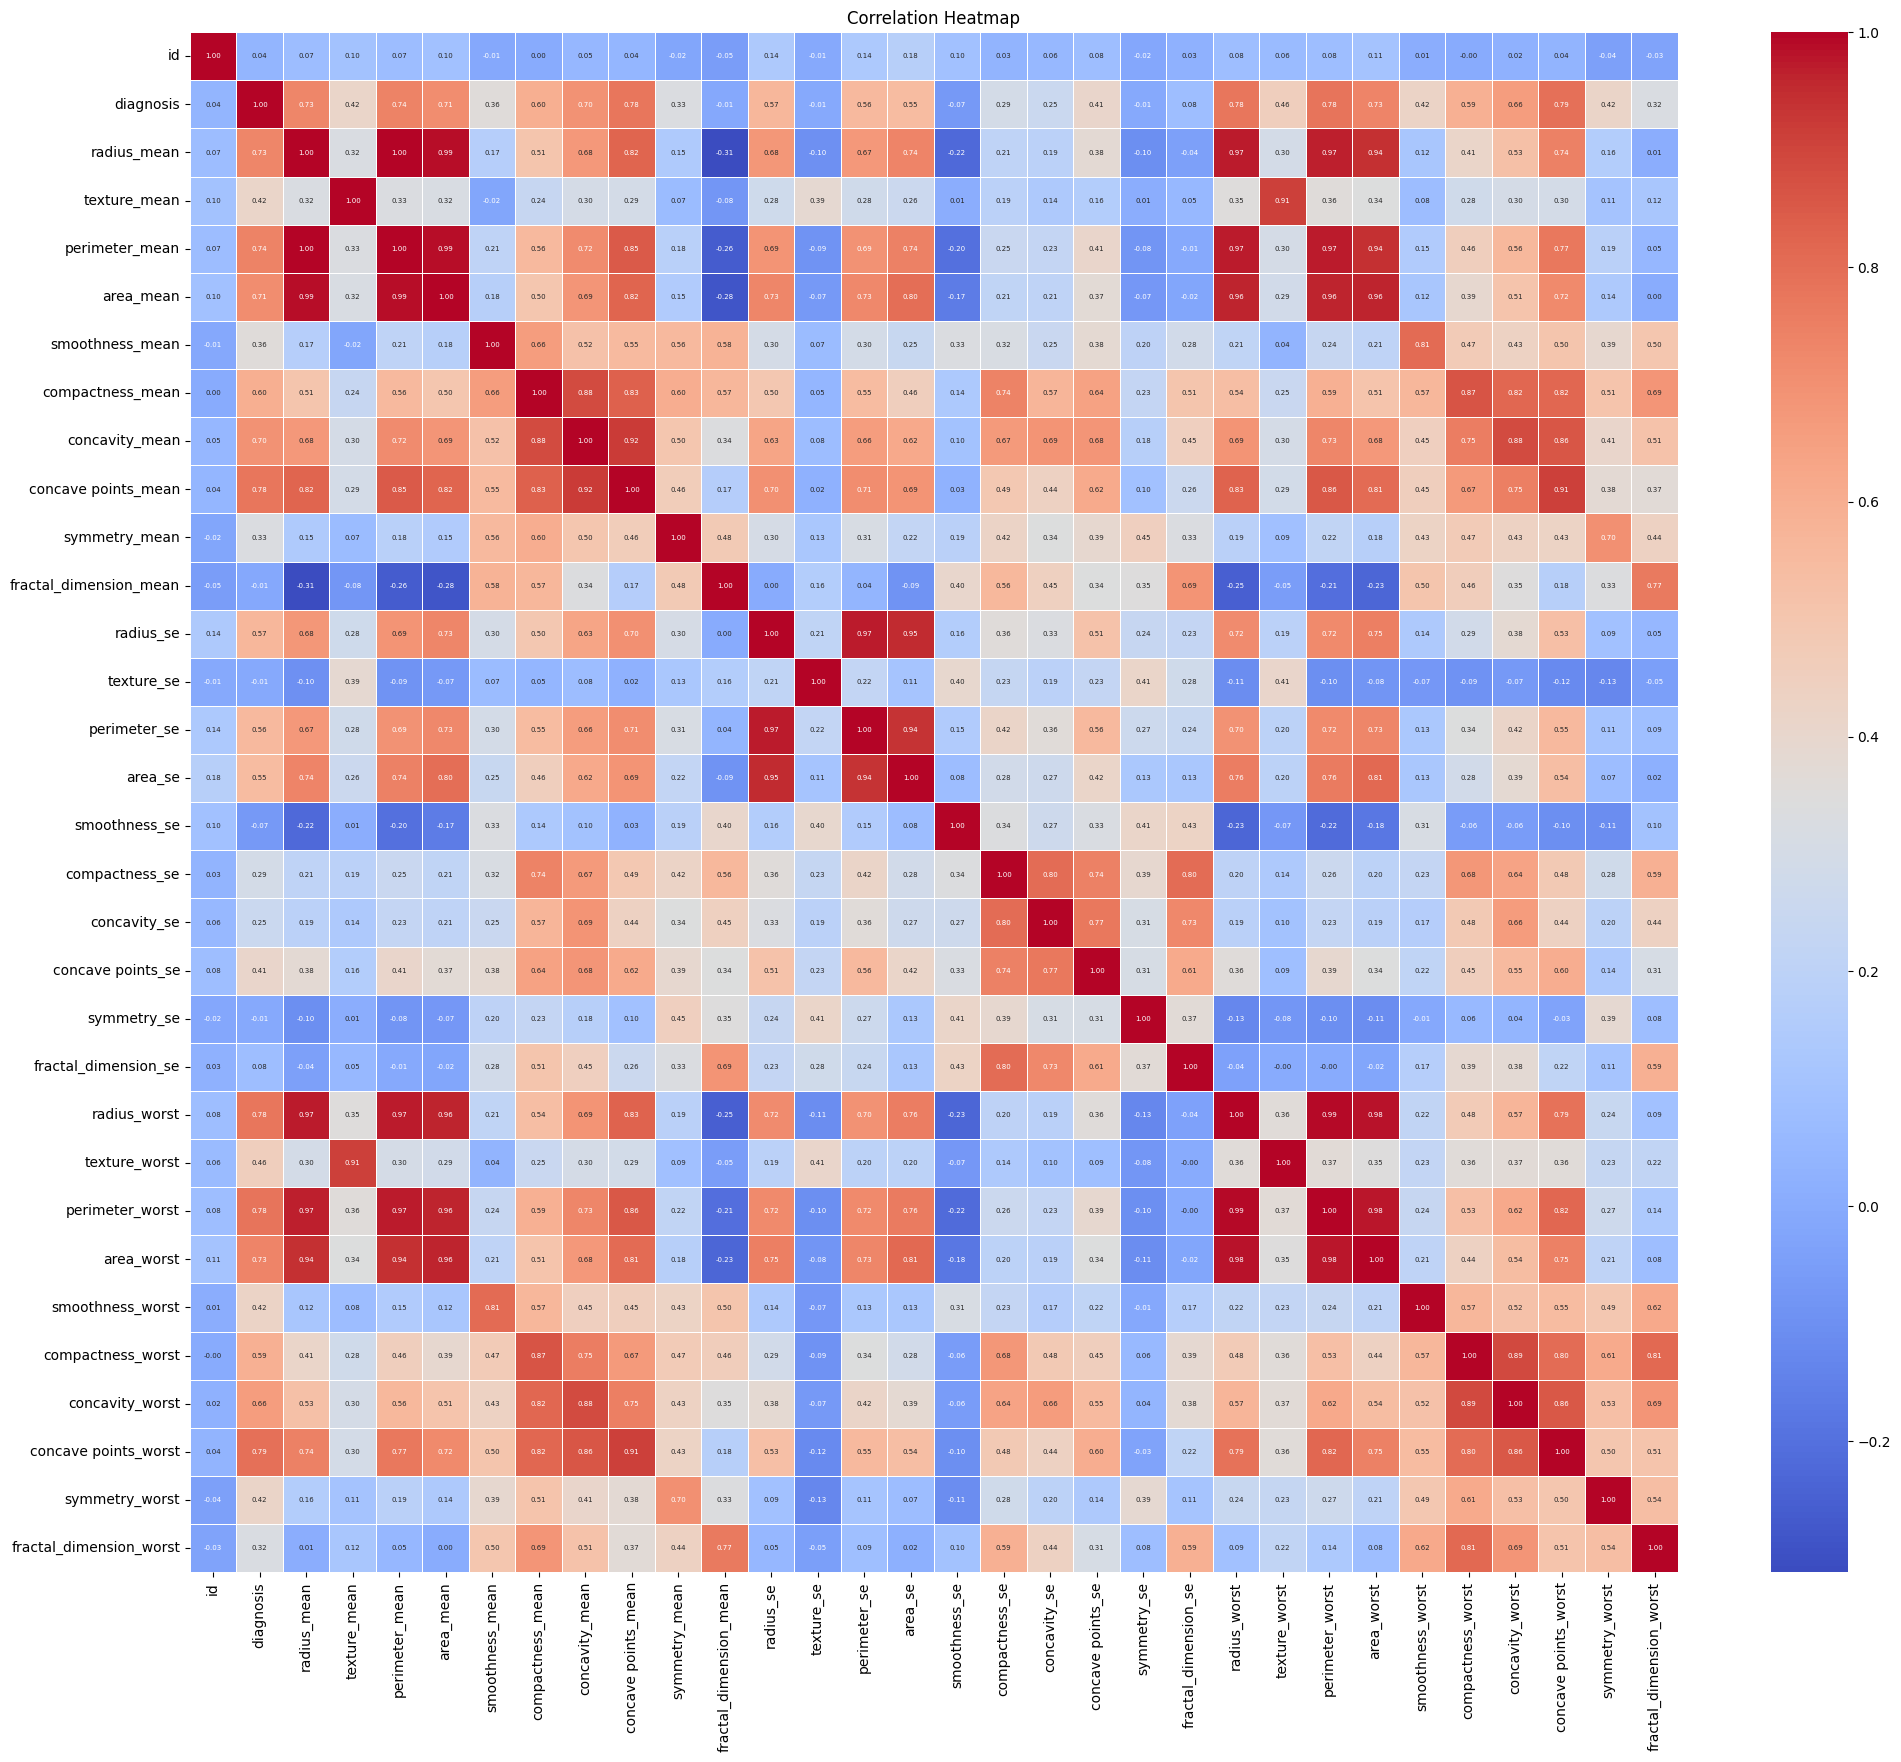

k                              Method           Classifier  Accuracy
0    3                         Chi-Squared  Logistic Regression    0.9227
1    3                         Chi-Squared        Random Forest    0.9086
2    3                         Chi-Squared  K-Nearest Neighbors    0.9192
3    3     Forward Feature Selection (FFS)  Logistic Regression    0.9561
4    3     Forward Feature Selection (FFS)        Random Forest    0.9596
5    3     Forward Feature Selection (FFS)  K-Nearest Neighbors    0.9719
6    3  Backward Feature Elimination (BFE)  Logistic Regression    0.9561
7    3  Backward Feature Elimination (BFE)        Random Forest    0.9578
8    3  Backward Feature Elimination (BFE)  K-Nearest Neighbors    0.9719
9    3  Principal Component Analysis (PCA)  Logistic Regression    0.9508
10   3  Principal Component Analysis (PCA)        Random Forest    0.9456
11   3  Principal Component Analysis (PCA)  K-Nearest Neighbors    0.9438
12   5                         Chi-Squared  Logistic Regression    0.9420
13   5                         Chi-Squared        Random Forest    0.9456
14   5                         Chi-Squared  K-Nearest Neighbors    0.9385
15   5     Forward Feature Selection (FFS)  Logistic Regression    0.9596
16   5     Forward Feature Selection (FFS)        Random Forest    0.9561
17   5     Forward Feature Selection (FFS)  K-Nearest Neighbors    0.9649
18   5  Backward Feature Elimination (BFE)  Logistic Regression    0.9596
19   5  Backward Feature Elimination (BFE)        Random Forest    0.9508
20   5  Backward Feature Elimination (BFE)  K-Nearest Neighbors    0.9596
21   5  Principal Component Analysis (PCA)  Logistic Regression    0.9666
22   5  Principal Component Analysis (PCA)        Random Forest    0.9613
23   5  Principal Component Analysis (PCA)  K-Nearest Neighbors    0.9561
24  10                         Chi-Squared  Logistic Regression    0.9350
25  10                         Chi-Squared        Random Forest    0.9403
26  10                         Chi-Squared  K-Nearest Neighbors    0.9367
27  10     Forward Feature Selection (FFS)  Logistic Regression    0.9684
28  10     Forward Feature Selection (FFS)        Random Forest    0.9649
29  10     Forward Feature Selection (FFS)  K-Nearest Neighbors    0.9631
30  10  Backward Feature Elimination (BFE)  Logistic Regression    0.9666
31  10  Backward Feature Elimination (BFE)        Random Forest    0.9596
32  10  Backward Feature Elimination (BFE)  K-Nearest Neighbors    0.9684
33  10  Principal Component Analysis (PCA)  Logistic Regression    0.9666
34  10  Principal Component Analysis (PCA)        Random Forest    0.9561
35  10  Principal Component Analysis (PCA)  K-Nearest Neighbors    0.9701

In [163]:
c_cancer
# Checking for Null Values
null_check(c_cancer)
# No Null Values present hence Encoding Categorical Data to Numerical
c_cancer = transform_data(c_cancer)
# Detailed summary of Data types in DataFrame
print(c_cancer.info())
# Plotting the heatmap
plot_Heatmap(c_cancer)
c_cancer_results, c_cancer_benchmarks = fwpMethodsClassification(c_cancer, 'diagnosis')
display(c_cancer_results)

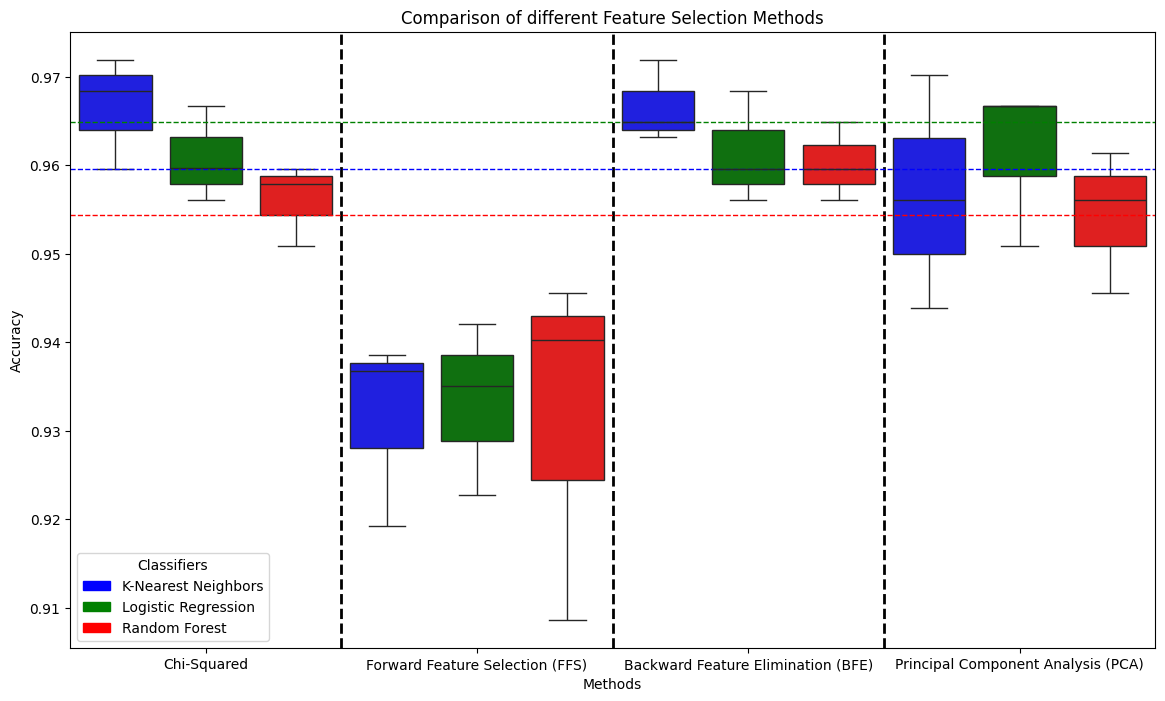

In [164]:
plot_results_boxplot(c_cancer_results, c_cancer_benchmarks)

### Interpretation:



## Dataset 2 : Mice Protein Expression Dataset (Classification)

Column Name: MouseID
Column DataType: object
Column unique values: ['309_1' '309_2' '309_3' ... 'J3295_13' 'J3295_14' 'J3295_15']
Column has null: False


Column Name: DYRK1A_N
Column DataType: float64
Column has null: True
Column Null Count: 3


Column Name: ITSN1_N
Column DataType: float64
Column has null: True
Column Null Count: 3


Column Name: BDNF_N
Column DataType: float64
Column has null: True
Column Null Count: 3


Column Name: NR1_N
Column DataType: float64
Column has null: True
Column Null Count: 3


Column Name: NR2A_N
Column DataType: float64
Column has null: True
Column Null Count: 3


Column Name: pAKT_N
Column DataType: float64
Column has null: True
Column Null Count: 3


Column Name: pBRAF_N
Column DataType: float64
Column has null: True
Column Null Count: 3


Column Name: pCAMKII_N
Column DataType: float64
Column has null: True
Column Null Count: 3


Column Name: pCREB_N
Column DataType: float64
Column has null: True
Column Null Count: 3


Column Name: pELK_N
Column D

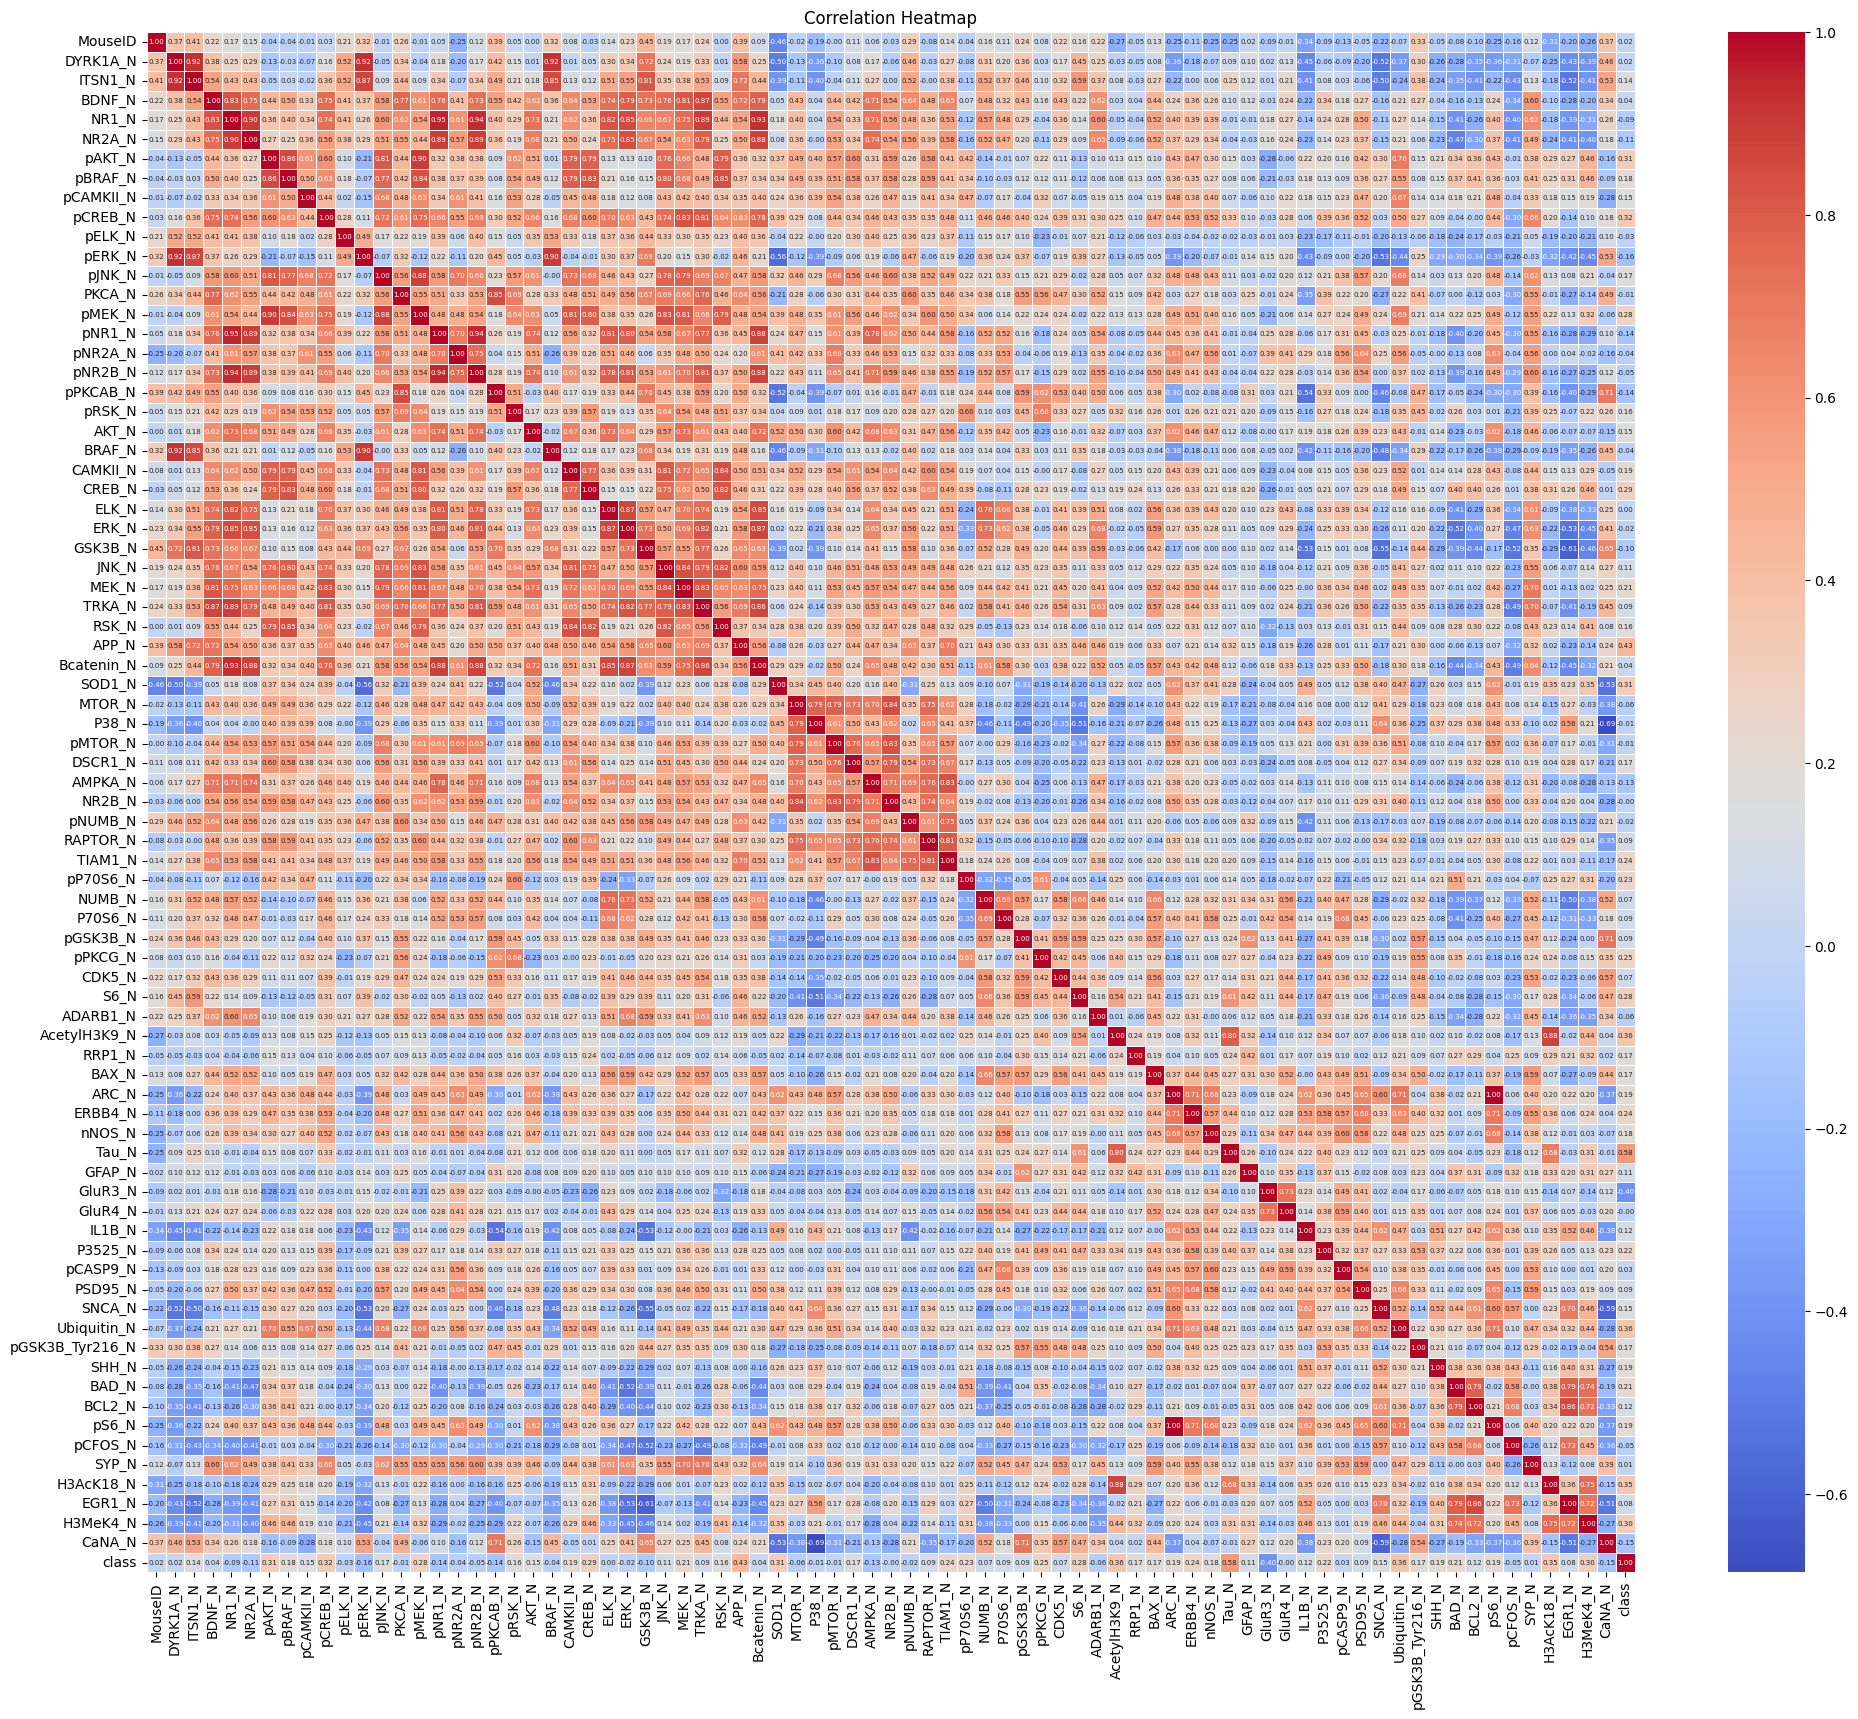

KeyboardInterrupt: 

In [165]:
c_mice_expression
# Checking for Null Values
null_check(c_mice_expression)
# Null Values present hence Removing the data
clean_data(c_mice_expression,[])
# No Null Values present hence Encoding Categorical Data to Numerical
c_mice_expression = transform_data(c_mice_expression)
# Detailed summary of Data types in DataFrame
print(c_mice_expression.info())
# Plotting the heatmap
plot_Heatmap(c_mice_expression)
c_mice_expression_results, c_mice_expression_benchmarks = fwpMethodsClassification(c_mice_expression, 'class')
display(c_mice_expression_results)

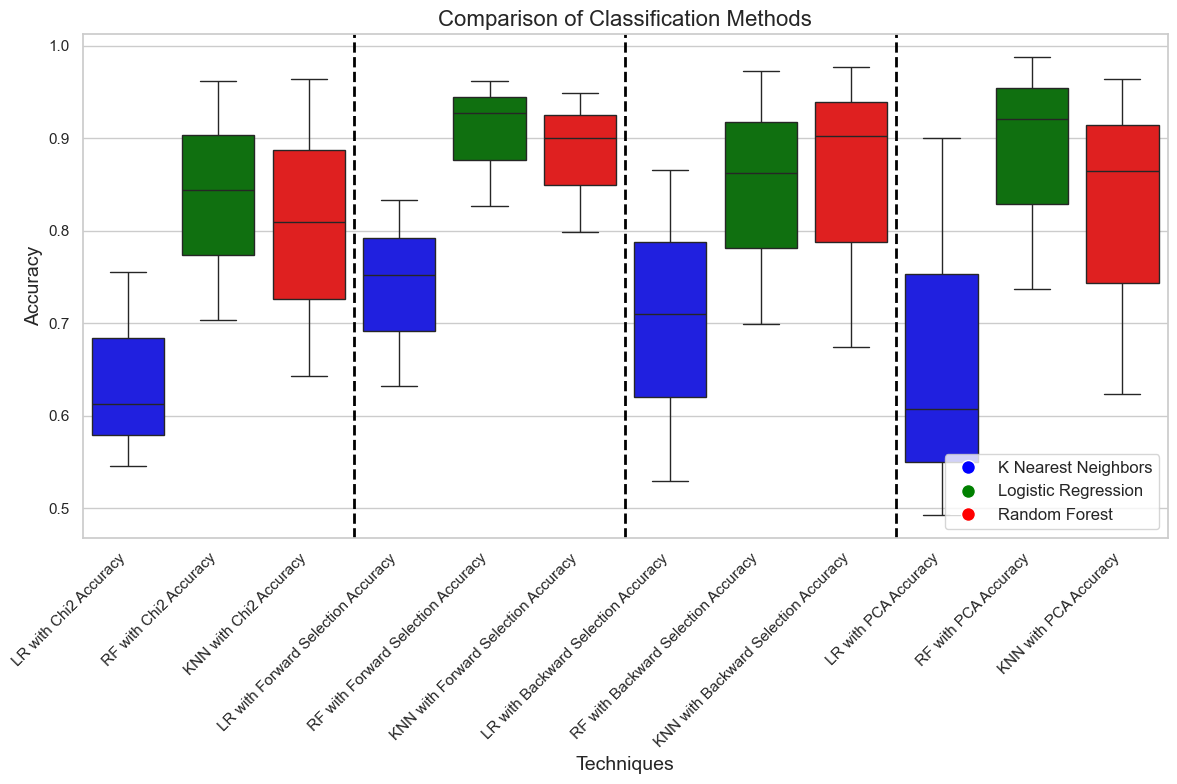

In [ ]:
plot_results_boxplot(c_mice_expression_results, c_mice_expression_benchmarks)

### Interpretation:



## Dataset 3 : Adult Income Dataset (Classification)

Column Name: age
Column DataType: float64
Column has null: False


Column Name: workclass
Column DataType: int32
Column unique values: [5 4 2 0 1 3 6]
Column has null: False


Column Name: fnlwgt
Column DataType: float64
Column has null: False


Column Name: education
Column DataType: int32
Column unique values: [ 9 11  1 12  6 15  7  5 10  8 14  4  0 13  2  3]
Column has null: False


Column Name: education-num
Column DataType: float64
Column has null: False


Column Name: marital-status
Column DataType: int32
Column unique values: [4 2 0 3 5 1 6]
Column has null: False


Column Name: occupation
Column DataType: int32
Column unique values: [ 0  3  5  9  7 11 13  4  6 12  2 10  1  8]
Column has null: False


Column Name: relationship
Column DataType: int32
Column unique values: [1 0 5 3 4 2]
Column has null: False


Column Name: race
Column DataType: int32
Column unique values: [4 2 1 0 3]
Column has null: False


Column Name: sex
Column DataType: int32
Column unique values: [1 0]
Colu

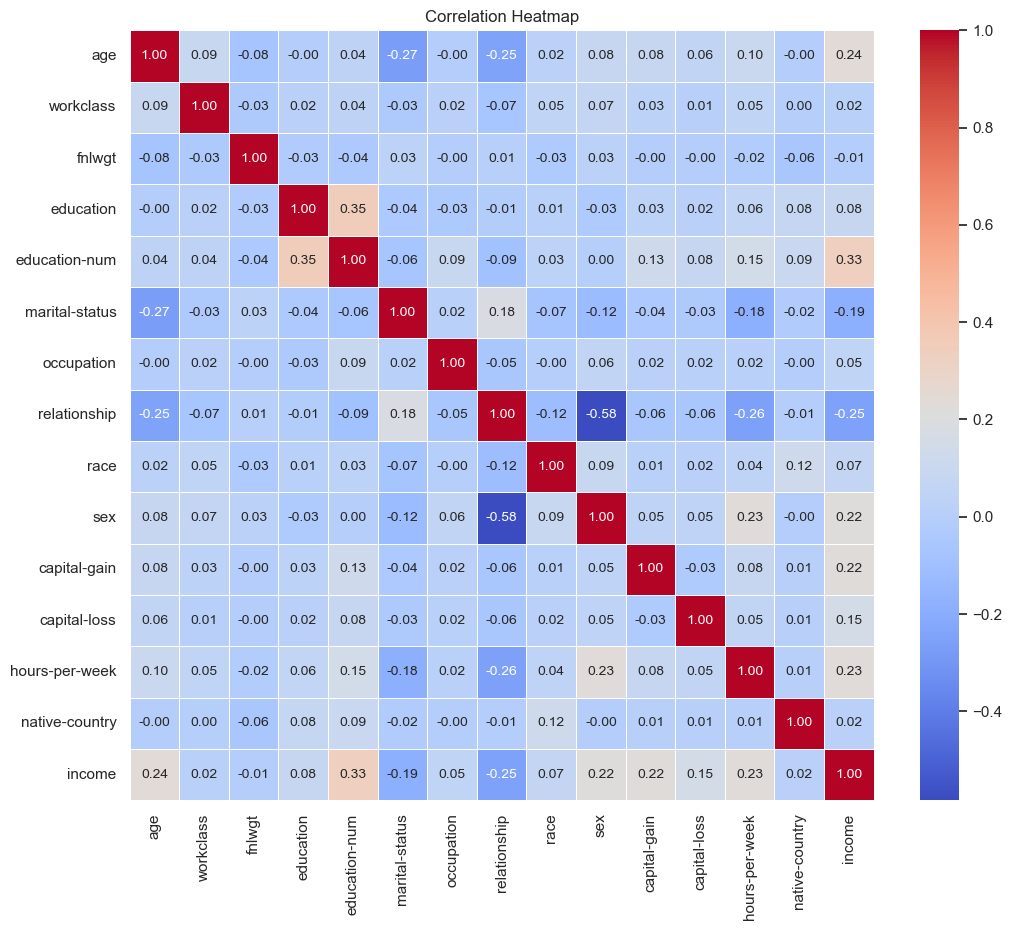

k  LR with Chi2 Accuracy  RF with Chi2 Accuracy  KNN with Chi2 Accuracy  \
0   3                 0.7896                 0.8036                  0.7546   
1   5                 0.7953                 0.8230                  0.7947   
2  10                 0.8182                 0.8418                  0.8225   

   LR with Forward Selection Accuracy  RF with Forward Selection Accuracy  \
0                              0.8055                              0.8254   
1                              0.8044                              0.7530   
2                              0.8000                              0.8274   

   KNN with Forward Selection Accuracy  LR with Backward Selection Accuracy  \
0                               0.8040                               0.8195   
1                               0.7778                               0.8264   
2                               0.8193                               0.8241   

   RF with Backward Selection Accuracy  KNN with Backward Selection Accuracy  \
0                               0.8454                                0.7951   
1                               0.8449                                0.8055   
2                               0.8266                                0.8219   

   LR with PCA Accuracy  RF with PCA Accuracy  KNN with PCA Accuracy  
0                0.7600                0.8095                 0.8090  
1                0.7583                0.8101                 0.8086  
2                0.8028                0.8187                 0.8137

In [ ]:
c_adult_income
# Checking for Null Values
null_check(c_adult_income)
# Null Values present hence Removing the data
clean_data(c_adult_income,[])
# No Null Values present hence Encoding Categorical Data to Numerical
c_adult_income = transform_data(c_adult_income)
# Detailed summary of Data types in DataFrame
print(c_adult_income.info())
# Plotting the heatmap
plot_Heatmap(c_adult_income)
c_adult_income_results, c_adult_income_benchmarks = fwpMethodsClassification(c_adult_income, 'income')
display(c_adult_income_results)

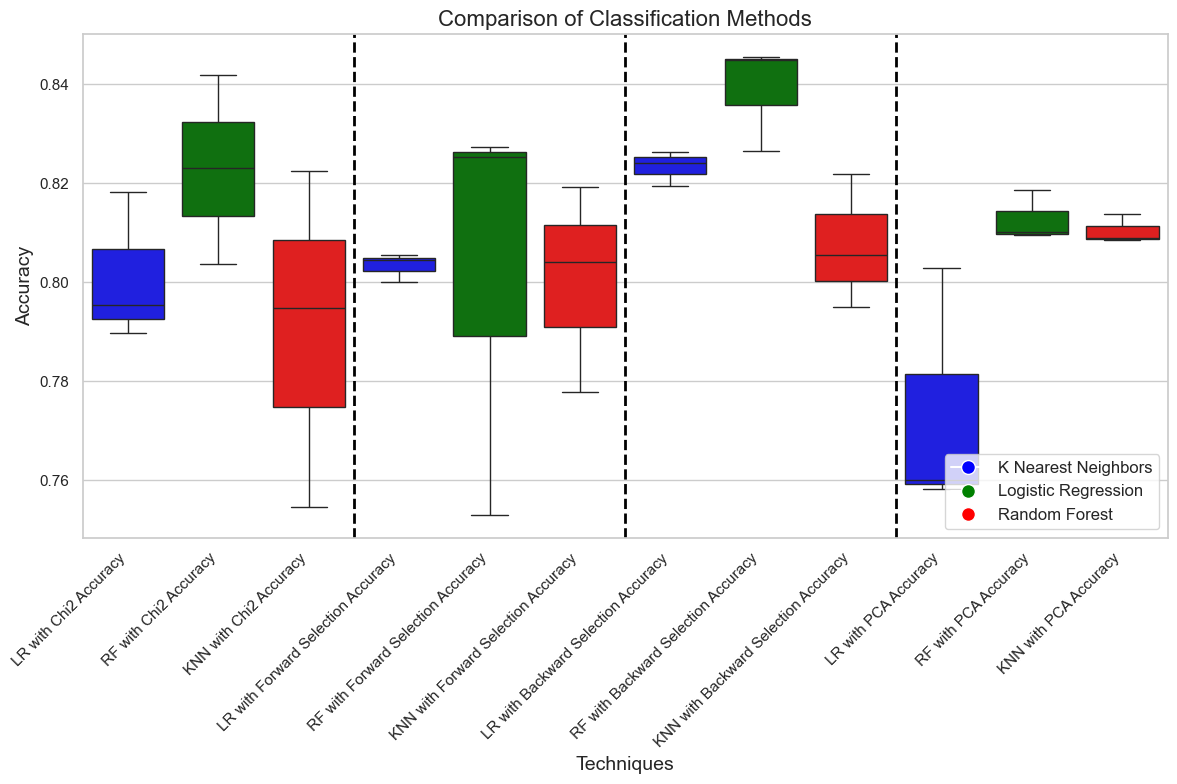

In [ ]:
plot_results_boxplot(c_adult_income_results, c_adult_income_benchmarks)

### Interpretation:



# Regression Datasets

## Dataset 4 : Life Expectancy Dataset (Regression)

Column Name: Country
Column DataType: object
Column unique values: ['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antigua and Barbuda'
 'Argentina' 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bahamas'
 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus' 'Belgium' 'Belize' 'Benin'
 'Bhutan' 'Bolivia (Plurinational State of)' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei Darussalam' 'Bulgaria' 'Burkina Faso'
 'Burundi' "Côte d'Ivoire" 'Cabo Verde' 'Cambodia' 'Cameroon' 'Canada'
 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia' 'Comoros'
 'Congo' 'Cook Islands' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czechia'
 "Democratic People's Republic of Korea"
 'Democratic Republic of the Congo' 'Denmark' 'Djibouti' 'Dominica'
 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji' 'Finland' 'France' 'Gabon' 'Gambia'
 'Georgia' 'Germany' 'Ghana' 'Greece' 'Grenada' 'Guatemala' 'Guinea'
 'Guinea-Bissau' 'Guyana' 'Haiti' 'Honduras' 'H

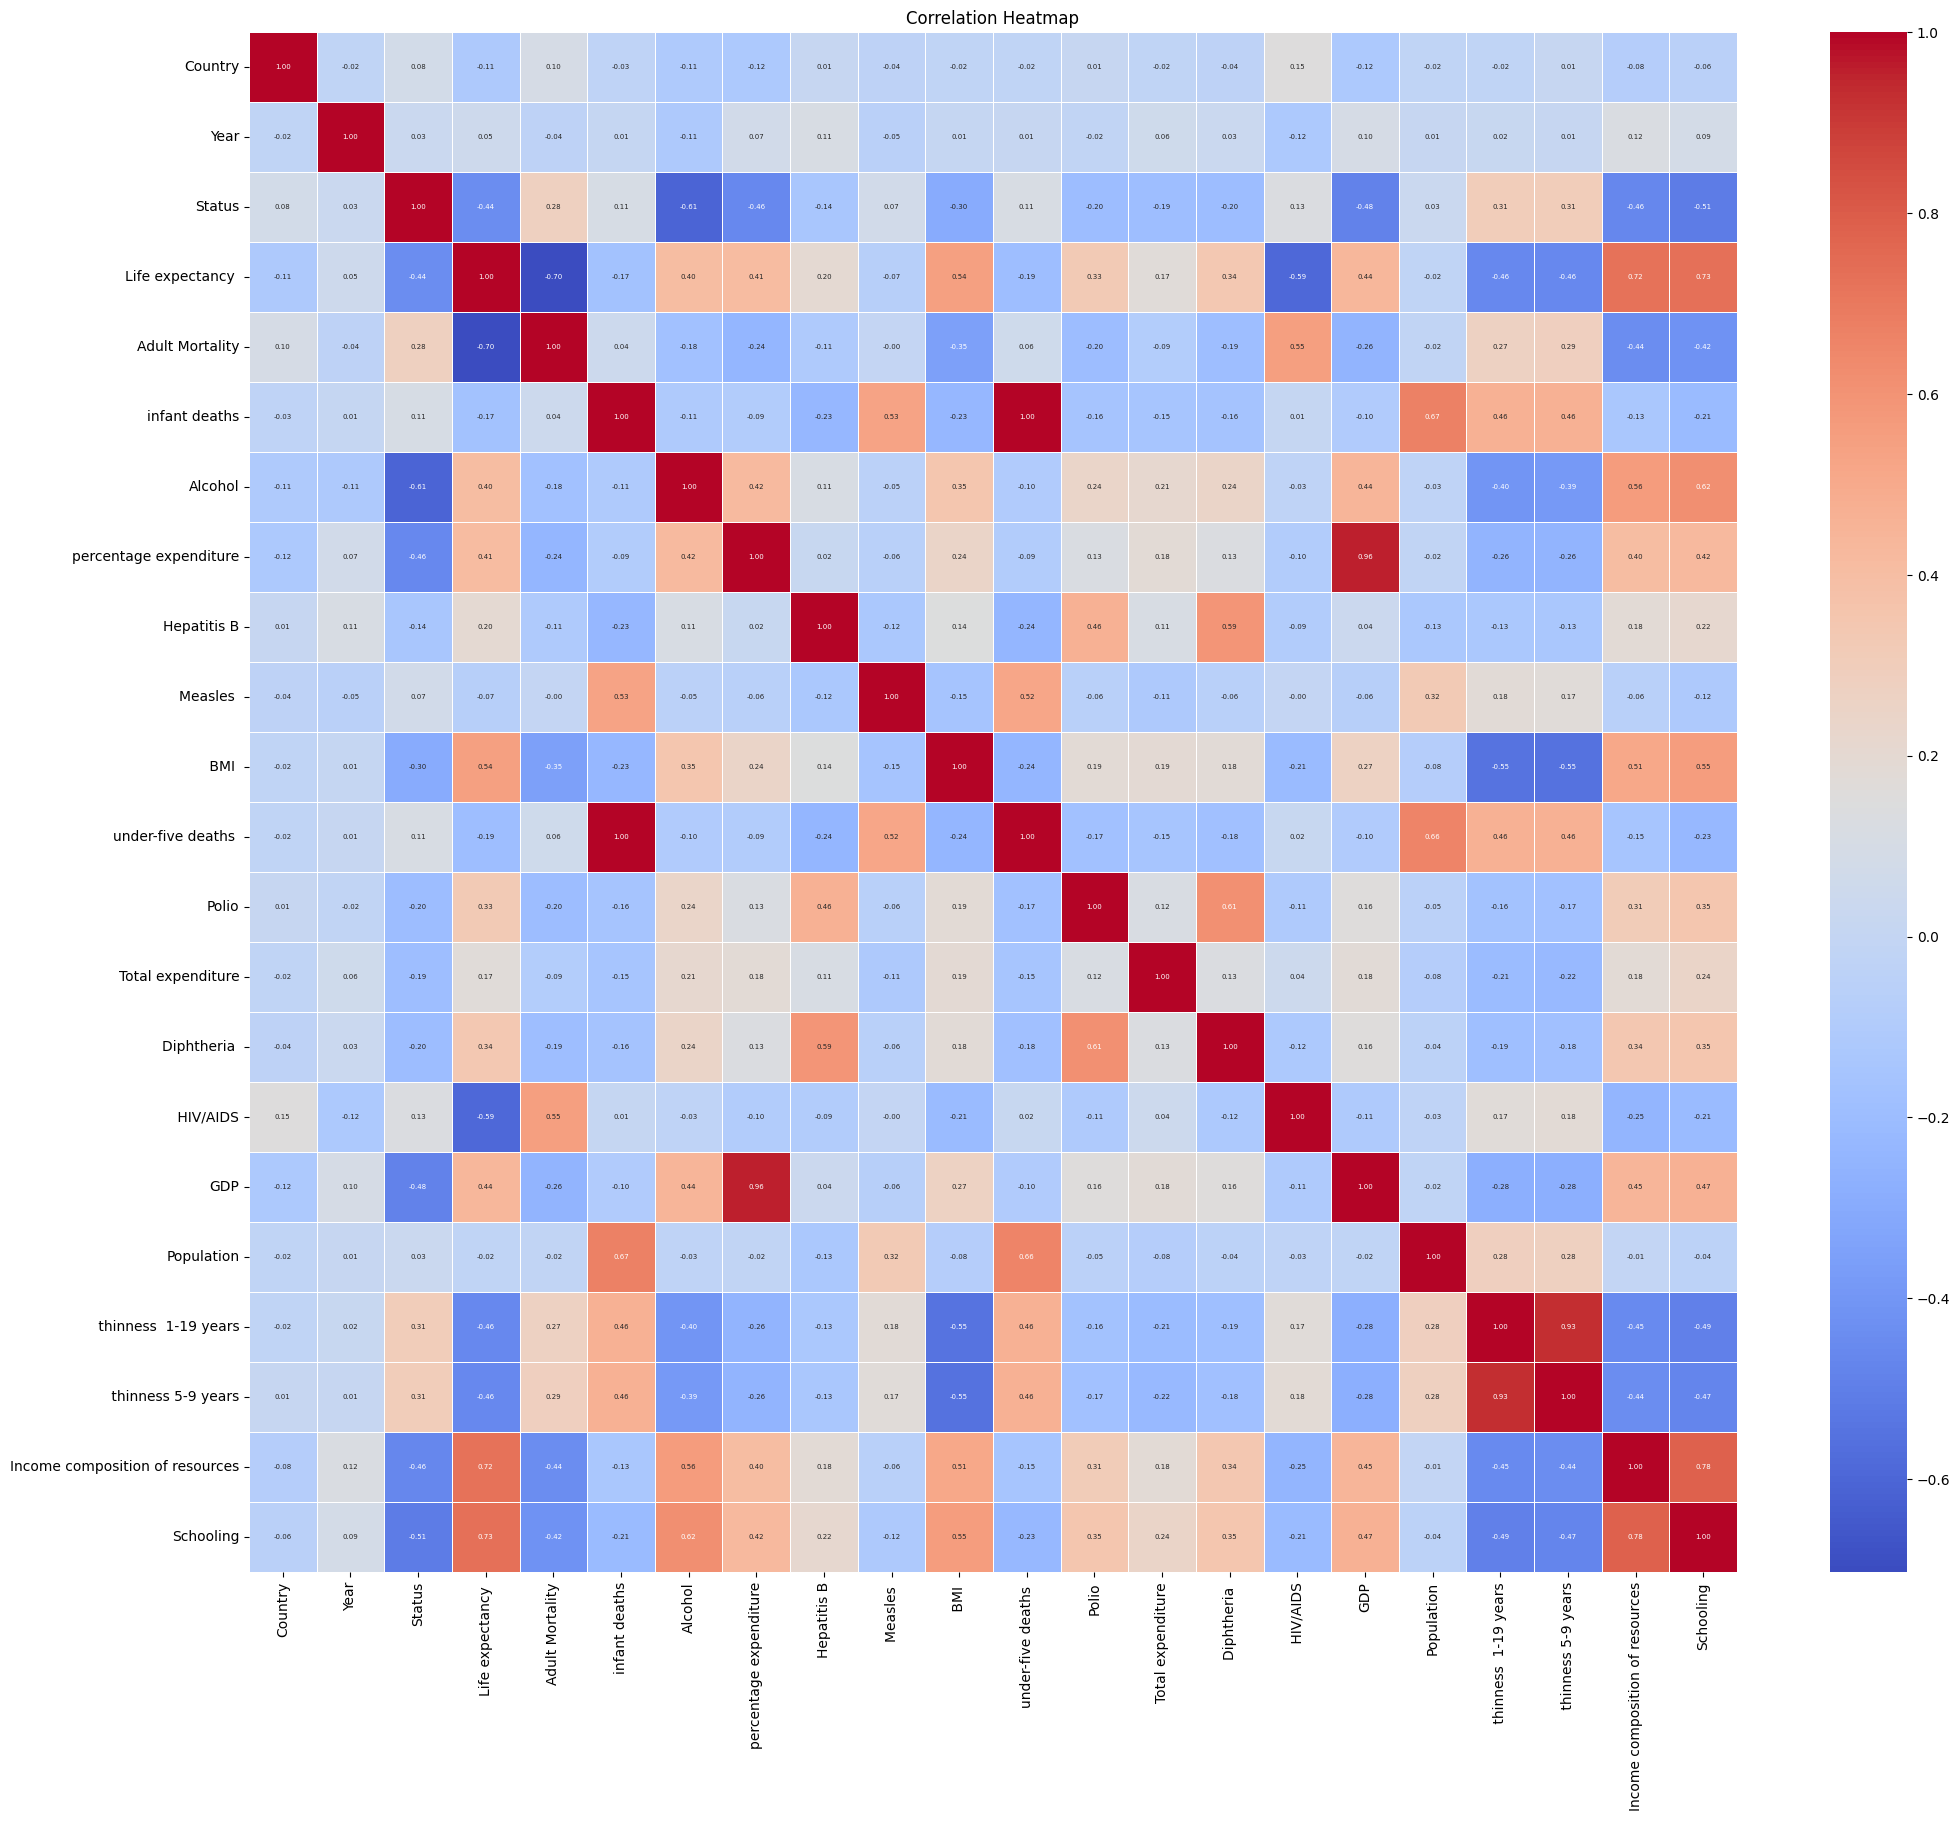

k                              Method            Regressor    MSE     R2
0    3                               Anova    Linear Regression 0.2617 0.7363
1    3                               Anova        Random Forest 0.0639 0.9352
2    3                               Anova  K-Nearest Neighbors 0.0784 0.9215
3    3     Forward Feature Selection (FFS)    Linear Regression 0.2452 0.7504
4    3     Forward Feature Selection (FFS)        Random Forest 0.0580 0.9411
5    3     Forward Feature Selection (FFS)  K-Nearest Neighbors 0.0653 0.9339
6    3  Backward Feature Elimination (BFE)    Linear Regression 0.2147 0.7840
7    3  Backward Feature Elimination (BFE)        Random Forest 0.0602 0.9399
8    3  Backward Feature Elimination (BFE)  K-Nearest Neighbors 0.0779 0.9214
9    3  Principal Component Analysis (PCA)    Linear Regression 0.4881 0.5093
10   3  Principal Component Analysis (PCA)        Random Forest 0.3482 0.6477
11   3  Principal Component Analysis (PCA)  K-Nearest Neighbors 0.3427 0.6549
12   5                               Anova    Linear Regression 0.1902 0.8075
13   5                               Anova        Random Forest 0.0486 0.9512
14   5                               Anova  K-Nearest Neighbors 0.0702 0.9290
15   5     Forward Feature Selection (FFS)    Linear Regression 0.1902 0.8075
16   5     Forward Feature Selection (FFS)        Random Forest 0.0481 0.9504
17   5     Forward Feature Selection (FFS)  K-Nearest Neighbors 0.0702 0.9290
18   5  Backward Feature Elimination (BFE)    Linear Regression 0.1902 0.8075
19   5  Backward Feature Elimination (BFE)        Random Forest 0.0483 0.9515
20   5  Backward Feature Elimination (BFE)  K-Nearest Neighbors 0.0702 0.9290
21   5  Principal Component Analysis (PCA)    Linear Regression 0.4189 0.5784
22   5  Principal Component Analysis (PCA)        Random Forest 0.2935 0.7034
23   5  Principal Component Analysis (PCA)  K-Nearest Neighbors 0.2923 0.7062
24  10                               Anova    Linear Regression 0.1855 0.8124
25  10                               Anova        Random Forest 0.0461 0.9531
26  10                               Anova  K-Nearest Neighbors 0.0763 0.9229
27  10     Forward Feature Selection (FFS)    Linear Regression 0.1791 0.8191
28  10     Forward Feature Selection (FFS)        Random Forest 0.0493 0.9503
29  10     Forward Feature Selection (FFS)  K-Nearest Neighbors 0.1060 0.8928
30  10  Backward Feature Elimination (BFE)    Linear Regression 0.1692 0.8287
31  10  Backward Feature Elimination (BFE)        Random Forest 0.0463 0.9513
32  10  Backward Feature Elimination (BFE)  K-Nearest Neighbors 0.1023 0.8964
33  10  Principal Component Analysis (PCA)    Linear Regression 0.2077 0.7902
34  10  Principal Component Analysis (PCA)        Random Forest 0.1389 0.8583
35  10  Principal Component Analysis (PCA)  K-Nearest Neighbors 0.1565 0.8430

In [183]:
r_life_expectancy
# Checking for Null Values
null_check(r_life_expectancy)
# Null Values present hence Removing the data
clean_data(r_life_expectancy,[])
# Encoding Categorical Data to Numerical
r_life_expectancy = transform_data(r_life_expectancy)
print(r_life_expectancy.info())
# Plotting the heatmap
plot_Heatmap(r_life_expectancy)
r_life_expectancy_results, r_life_expectancy_benchmarks = fwpMethodsRegression(r_life_expectancy, 'Life expectancy ')
display(r_life_expectancy_results)

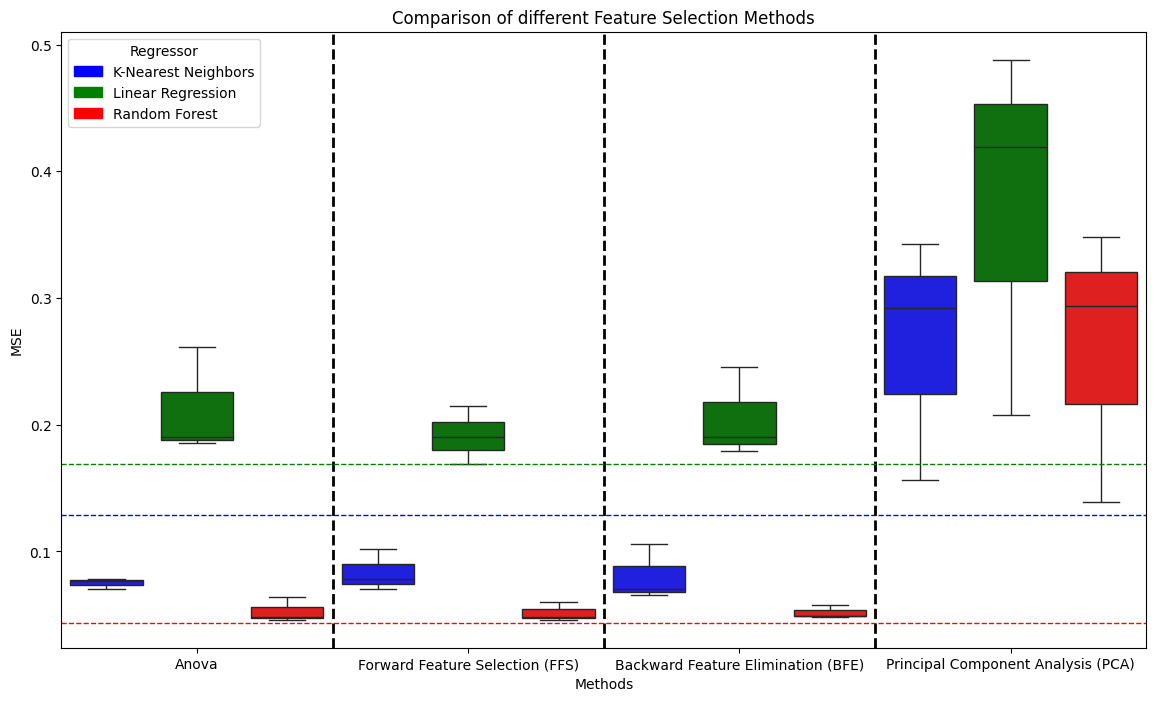

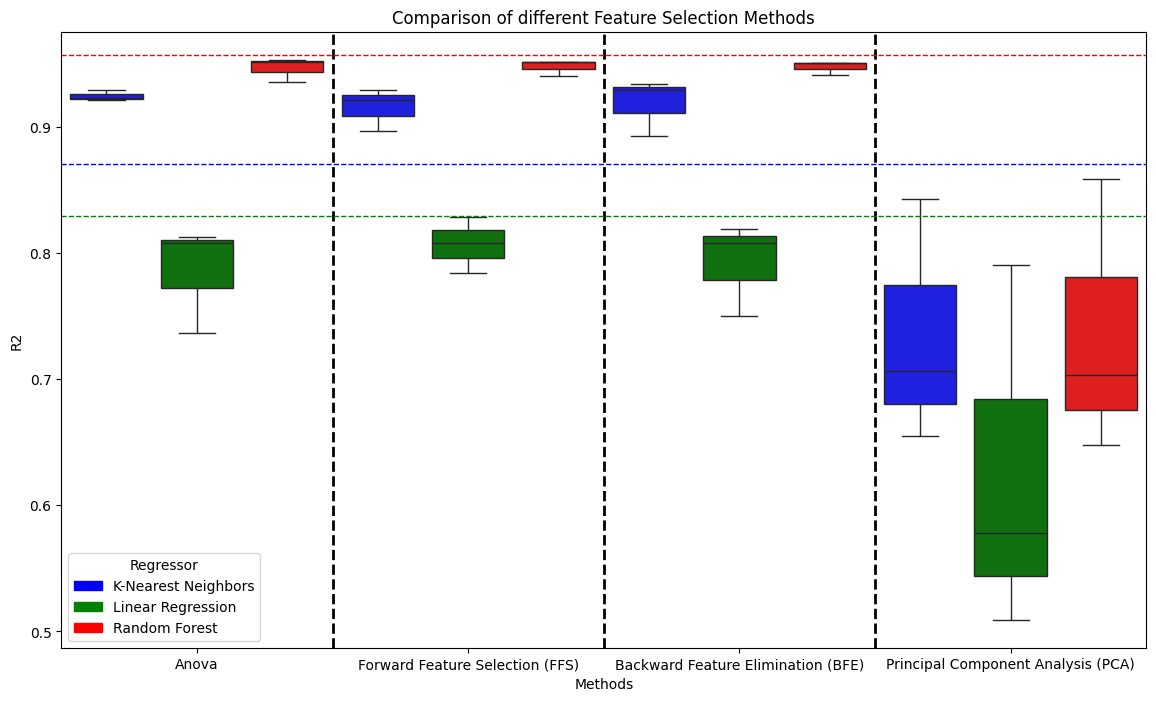

In [197]:
plot_results_boxplot_r(r_life_expectancy_results, r_life_expectancy_benchmarks)

### Interpretation:



## Dataset 5 : Appartment Rent Estimation (Regression)

Column Name: id
Column DataType: int64
Column has null: False


Column Name: category
Column DataType: object
Column unique values: ['housing/rent/apartment' 'housing/rent/home' 'housing/rent/short_term']
Column has null: False


Column Name: amenities
Column DataType: object
Column unique values: ['Unknown' 'Fireplace,Gym,Parking,Pool,Storage,Wood Floors' 'Gated,Pool'
 ... 'AC,Cable or Satellite,Elevator,Internet Access,Wood Floors'
 'Elevator,Washer Dryer'
 'AC,Cable or Satellite,Parking,Pool,Washer Dryer,Wood Floors']
Column has null: False


Column Name: bathrooms
Column DataType: float64
Column has null: False


Column Name: bedrooms
Column DataType: int64
Column has null: False


Column Name: currency
Column DataType: object
Column unique values: ['USD']
Column has null: False


Column Name: fee
Column DataType: object
Column unique values: ['No']
Column has null: False


Column Name: has_photo
Column DataType: object
Column unique values: ['Thumbnail' 'No' 'Yes']
Column has null

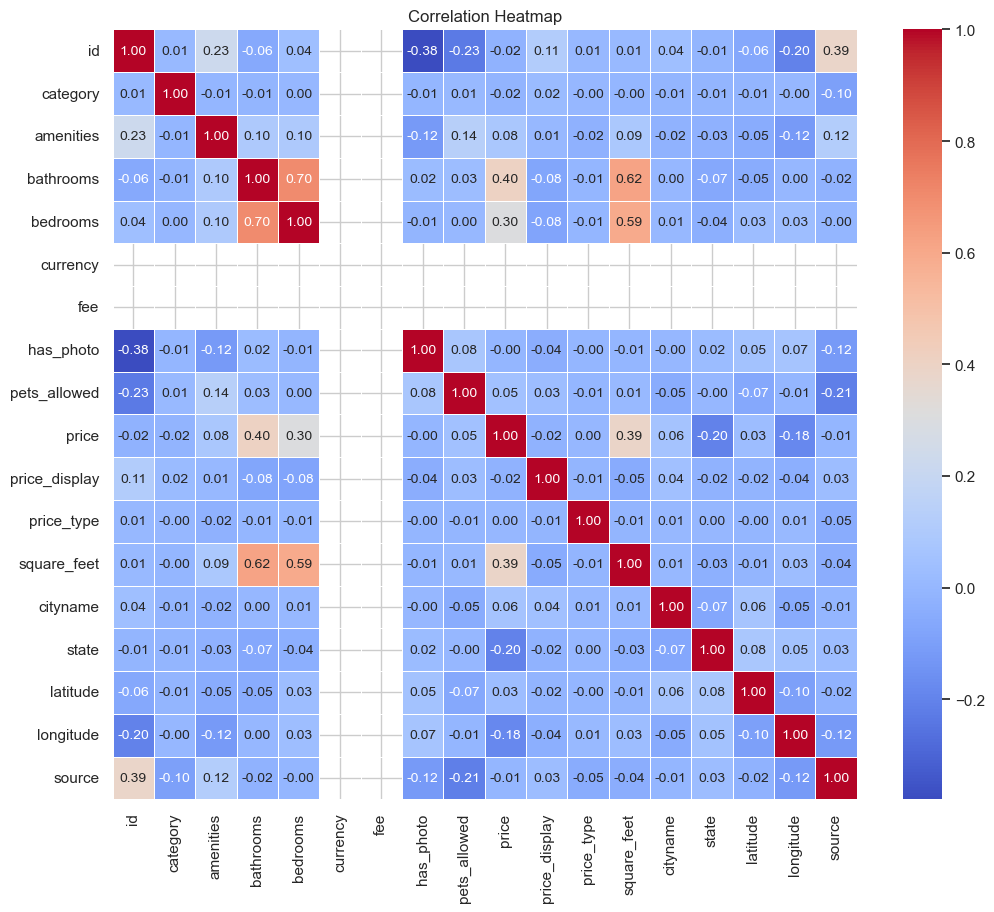

k  LR with Forward Selection MSE  RF with Forward Selection MSE  \
0   3                         0.7789                         0.5728   
1   5                         0.7927                         0.4805   
2  10                         0.7909                         0.4812   

   KNN with Forward Selection MSE  LR with Backward Selection MSE  \
0                          0.5606                          0.7789   
1                          0.5307                          0.7927   
2                          0.6103                          0.7909   

   RF with Backward Selection MSE  KNN with Backward Selection MSE  \
0                          0.5884                           0.5606   
1                          0.4795                           0.5307   
2                          0.4906                           0.6103   

   LR with PCA MSE  RF with PCA MSE  KNN with PCA MSE  LR with ANOVA MSE  \
0           0.9953           0.7576            0.8224             0.8768   
1           0.9453           0.6416            0.6187             0.8149   
2           0.8002           0.5271            0.4660             0.8129   

   RF with ANOVA MSE  KNN with ANOVA MSE  LR with ANOVA MAE  \
0             0.9265              0.8558             0.4957   
1             0.4898              0.5431             0.4754   
2             0.3491              0.4384             0.4694   

   RF with ANOVA MAE  KNN with ANOVA MAE  LR with ANOVA R-squared  \
0             0.5178              0.5147                   0.1148   
1             0.2667              0.3023                   0.1836   
2             0.0368              0.1367                   0.1859   

   RF with ANOVA R-squared  KNN with ANOVA R-squared  
0                   0.0525                    0.1495  
1                   0.5861                    0.5200  
2                   0.7409                    0.6643

In [127]:
r_appartment_rent
# Checking for Null Values
null_check(r_appartment_rent)
# No Null Values present hence Encoding Categorical Data to Numerical
r_appartment_rent = transform_data(r_appartment_rent)
print(r_appartment_rent.info())
# Plotting the heatmap
plot_Heatmap(r_appartment_rent)
r_appartment_rent_results = fwpMethodsRegression(r_appartment_rent, 'price')
display(r_appartment_rent_results)

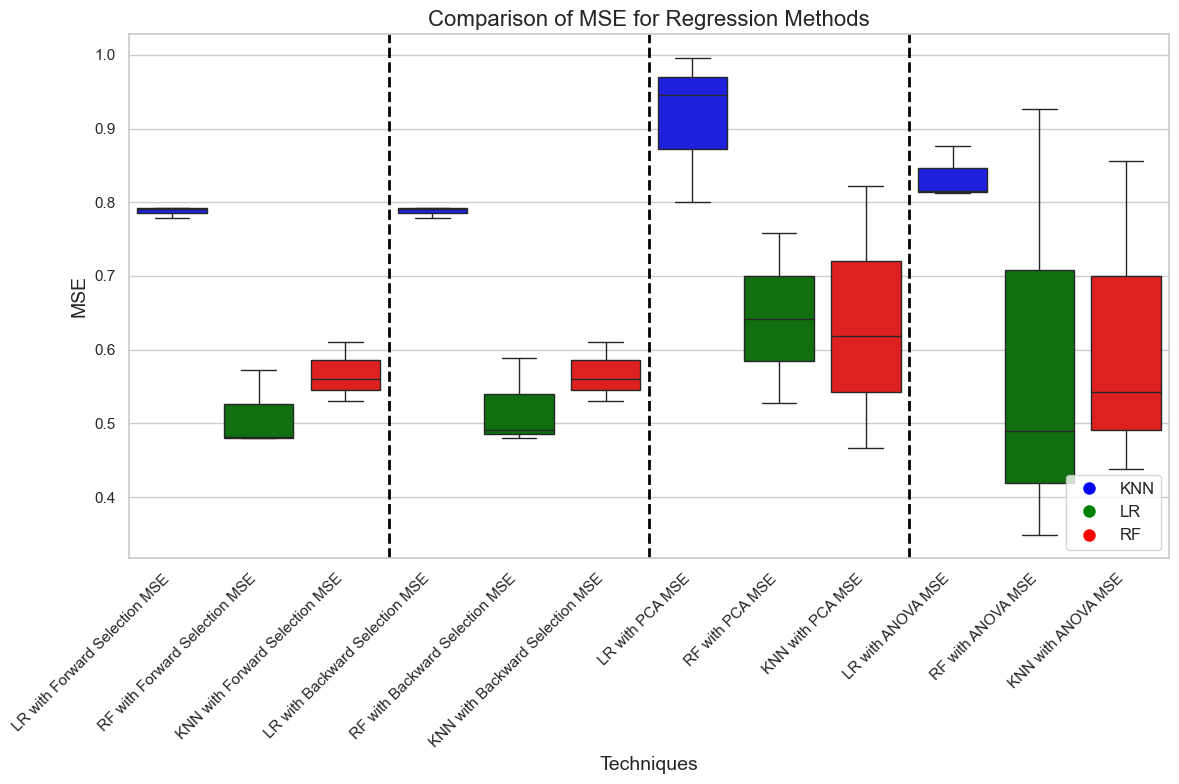

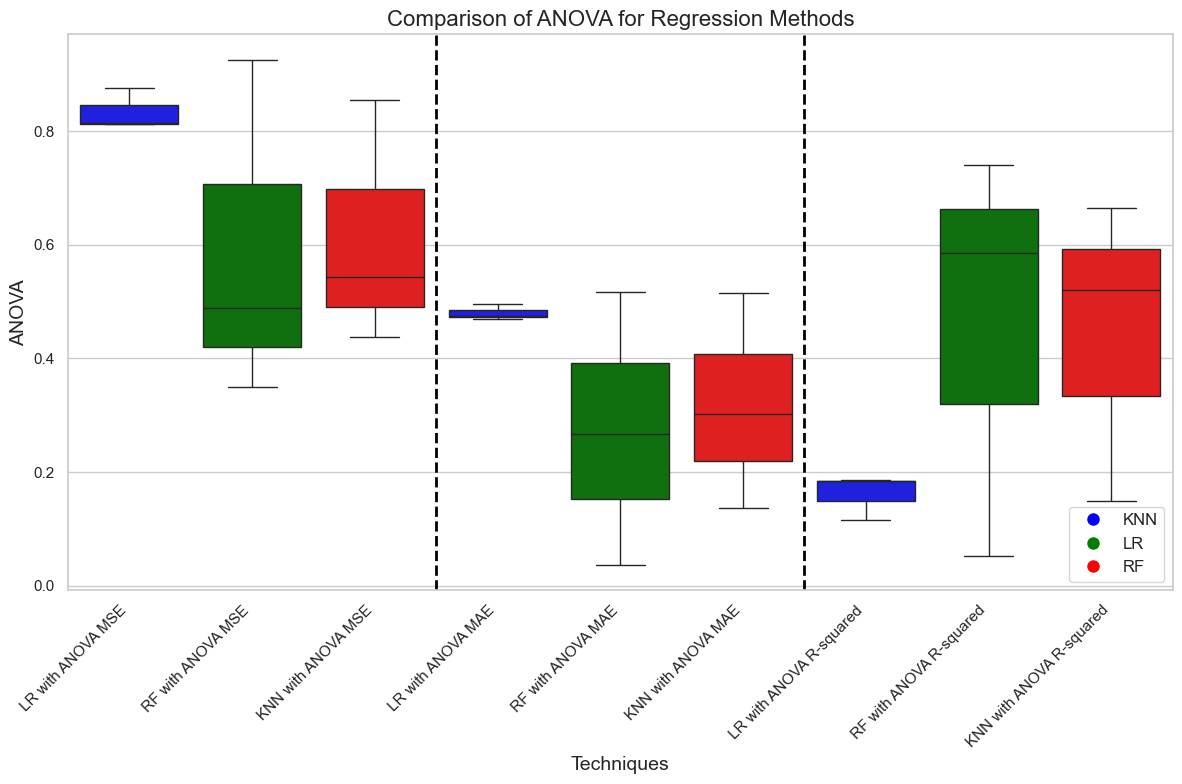

In [128]:
plot_results_boxplot_r(r_appartment_rent_results)

### Interpretation:


## Dataset 6 : Song Popularity Estimation (Regression)

Column Name: song_name
Column DataType: int32
Column unique values: [ 791 2825 4886 ... 2652 1447 1771]
Column has null: False


Column Name: song_popularity
Column DataType: float64
Column has null: False


Column Name: song_duration_ms
Column DataType: float64
Column has null: False


Column Name: acousticness
Column DataType: float64
Column has null: False


Column Name: danceability
Column DataType: float64
Column has null: False


Column Name: energy
Column DataType: float64
Column has null: False


Column Name: instrumentalness
Column DataType: float64
Column has null: False


Column Name: key
Column DataType: float64
Column has null: False


Column Name: liveness
Column DataType: float64
Column has null: False


Column Name: loudness
Column DataType: float64
Column has null: False


Column Name: audio_mode
Column DataType: float64
Column has null: False


Column Name: speechiness
Column DataType: float64
Column has null: False


Column Name: tempo
Column DataType: float64
Column

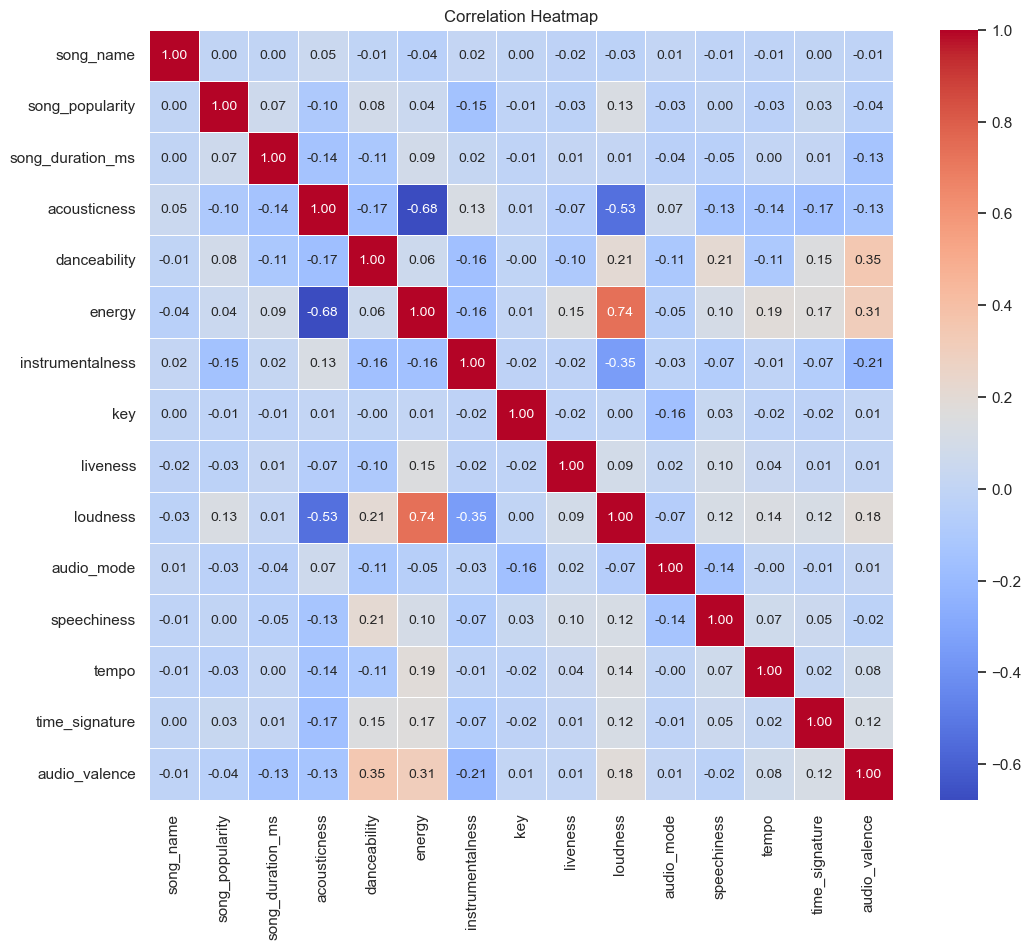

k  LR with Forward Selection MSE  RF with Forward Selection MSE  \
0   3                         0.9785                         0.8411   
1   5                         0.9740                         0.8097   
2  10                         0.9687                         0.7779   

   KNN with Forward Selection MSE  LR with Backward Selection MSE  \
0                          1.0625                          0.9723   
1                          1.0834                          0.9669   
2                          1.0557                          0.9664   

   RF with Backward Selection MSE  KNN with Backward Selection MSE  \
0                          0.8478                           1.0566   
1                          0.7737                           1.0206   
2                          0.7683                           1.0440   

   LR with PCA MSE  RF with PCA MSE  KNN with PCA MSE  LR with ANOVA MSE  \
0           0.9919           0.8482            1.0628             0.9706   
1           0.9918           0.8016            1.0555             0.9647   
2           0.9570           0.7564            1.0226             0.9515   

   RF with ANOVA MSE  KNN with ANOVA MSE  LR with ANOVA MAE  \
0             0.8317              1.0579             0.7880   
1             0.7734              1.0152             0.7846   
2             0.7359              1.0163             0.7795   

   RF with ANOVA MAE  KNN with ANOVA MAE  LR with ANOVA R-squared  \
0             0.6957              0.8124                   0.0286   
1             0.6635              0.7924                   0.0345   
2             0.6461              0.7908                   0.0478   

   RF with ANOVA R-squared  KNN with ANOVA R-squared  
0                   0.1654                   -0.0590  
1                   0.2296                   -0.0158  
2                   0.2608                   -0.0168

In [93]:
r_song_popularity
# Checking for Null Values
null_check(r_song_popularity)
# No Null Values present hence Encoding Categorical Data to Numerical
r_song_popularity = transform_data(r_song_popularity)
print(r_song_popularity.info())
# Plotting the heatmap
plot_Heatmap(r_song_popularity)
r_song_popularity_results = fwpMethodsRegression(r_song_popularity, 'song_popularity')
display(r_song_popularity_results)

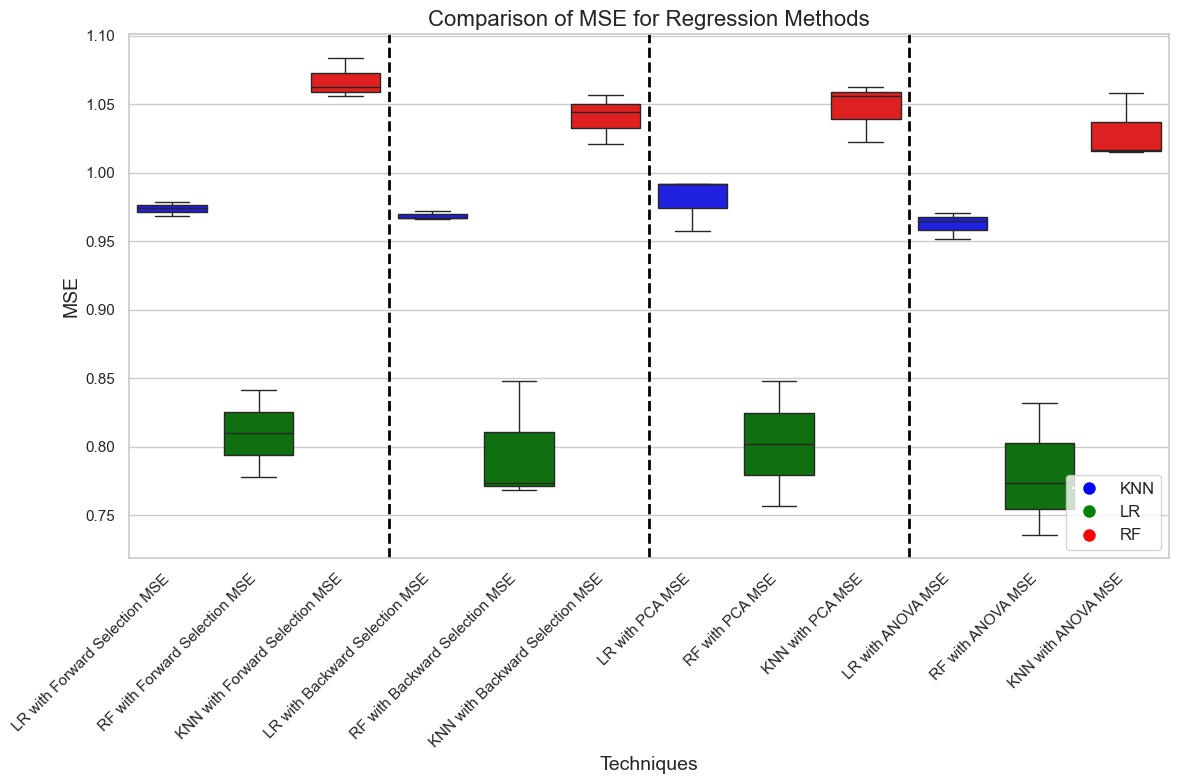

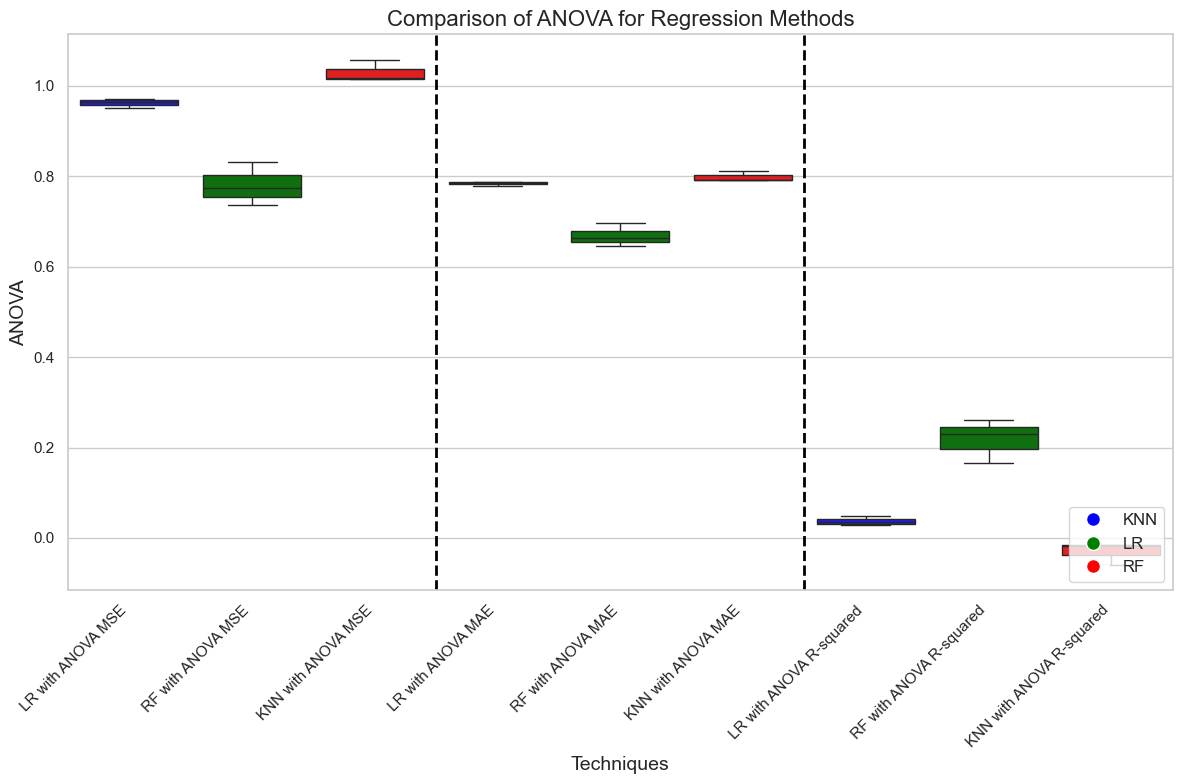

In [123]:
plot_results_boxplot_r(r_song_popularity_results)

### Interpretation:
